In [1]:
!wget https://huggingface.co/datasets/puhsu/tabular-benchmarks/resolve/main/data.tar -O tabular-dl-tabr.tar.gz
!tar -xvf tabular-dl-tabr.tar.gz

--2024-10-15 15:52:23--  https://huggingface.co/datasets/puhsu/tabular-benchmarks/resolve/main/data.tar
Resolving huggingface.co (huggingface.co)... 13.35.210.77, 13.35.210.66, 13.35.210.61, ...
Connecting to huggingface.co (huggingface.co)|13.35.210.77|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/1b/25/1b25d6e2556c827abfaf6ba9da6021338691cafc39fe9d77986955ae0a69243d/0d74e4b96febb48fbe4dd2d851f8638b5738354f82c3183f92adbd2abf2f256b?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27data.tar%3B+filename%3D%22data.tar%22%3B&response-content-type=application%2Fx-tar&Expires=1729266743&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyOTI2Njc0M319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy8xYi8yNS8xYjI1ZDZlMjU1NmM4MjdhYmZhZjZiYTlkYTYwMjEzMzg2OTFjYWZjMzlmZTlkNzc5ODY5NTVhZTBhNjkyNDNkLzBkNzRlNGI5NmZlYmI0OGZiZTRkZDJkODUxZjg2MzhiNTczODM1NGY4MmMzMTgzZjkyYWRiZDJhYmYyZjI1NmI%

In [2]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.0 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00


In [4]:
!pip install psutil

In [5]:
import pandas as pd
import numpy as np
import optuna
import torch.optim
import psutil

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import QuantileTransformer

In [6]:
tnr = TabNetRegressor()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [7]:
X_train = np.load('/content/data/regression-num-medium-0-wine_quality/X_num_train.npy')
y_train = np.load('/content/data/regression-num-medium-0-wine_quality/Y_train.npy').reshape(-1, 1)

X_valid = np.load('/content/data/regression-num-medium-0-wine_quality/X_num_val.npy')
y_valid = np.load('/content/data/regression-num-medium-0-wine_quality/Y_val.npy').reshape(-1, 1)

X_test = np.load('/content/data/regression-num-medium-0-wine_quality/X_num_test.npy')
y_test = np.load('/content/data/regression-num-medium-0-wine_quality/Y_test.npy').reshape(-1, 1)

In [8]:
normalizer = QuantileTransformer(
            output_distribution='normal',
            n_quantiles=max(min(X_train.shape[0] // 30, 1000), 10),
            subsample=1_000_000_000,
            )
normalizer.fit_transform(X_train)

array([[ 0.5927727 , -0.21897869,  0.11724408, ..., -0.9944579 ,
         1.1263912 ,  0.13408759],
       [-1.361571  , -0.6433454 , -0.73884684, ...,  0.0334279 ,
         0.01671162,  0.72791326],
       [-1.361571  , -0.9944579 , -0.3054808 , ...,  1.1584837 ,
        -0.8656782 ,  0.72791326],
       ...,
       [-0.9541652 , -0.02506888, -0.82977384, ..., -0.6640369 ,
         0.40338284, -0.28801754],
       [ 0.4215777 , -1.1263912 ,  0.01671162, ..., -0.72791326,
        -0.06689329, -1.1422904 ],
       [-0.56314915, -0.7498694 , -0.3054808 , ...,  0.16789399,
        -0.8656782 ,  1.1422904 ]], dtype=float32)

In [9]:
#Baseline
tnr.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae', 'rmse'],
)

epoch 0  | loss: 20.25212| train_mae: 8.525589942932129| train_rmse: 13.877189636230469| valid_mae: 9.05955982208252| valid_rmse: 15.522290229797363|  0:00:02s
epoch 1  | loss: 8.75538 | train_mae: 7.074530124664307| train_rmse: 14.28501033782959| valid_mae: 6.8660101890563965| valid_rmse: 14.858909606933594|  0:00:02s
epoch 2  | loss: 3.23983 | train_mae: 7.969649791717529| train_rmse: 15.585000038146973| valid_mae: 7.908289909362793| valid_rmse: 16.172290802001953|  0:00:03s
epoch 3  | loss: 2.52254 | train_mae: 8.19314956665039| train_rmse: 11.168560028076172| valid_mae: 7.811870098114014| valid_rmse: 10.700819969177246|  0:00:03s
epoch 4  | loss: 1.42859 | train_mae: 3.775739908218384| train_rmse: 6.026860237121582| valid_mae: 3.775599956512451| valid_rmse: 6.165800094604492|  0:00:03s
epoch 5  | loss: 0.92525 | train_mae: 2.473259925842285| train_rmse: 3.6284399032592773| valid_mae: 2.374300003051758| valid_rmse: 3.5759100914001465|  0:00:04s
epoch 6  | loss: 0.79518 | train_mae: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [10]:
def objective(trial):
    n_d = trial.suggest_int('n_d', 8, 64)
    n_a = n_d

    params = {
        #'n_d': trial.suggest_int('n_d', 8, 64),
        #'n_a': trial.suggest_int('n_a', 8, 64),
        'n_d': n_d,
        'n_a': n_a,
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'n_independent': trial.suggest_int('n_independent', 1, 5),
        'n_shared': trial.suggest_int('n_shared', 1, 5),
        'momentum': trial.suggest_float('momentum', 0.01, 0.4),
    }

    model = TabNetRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], patience=10)

    # Evaluate model performance
    score = model.best_cost  # or any other metric

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2024-10-15 15:53:32,334] A new study created in memory with name: no-name-220e3985-68e9-4323-a6d0-812614dd6276
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 57.03082| val_0_mse: 265.0199279785156|  0:00:00s
epoch 1  | loss: 40.41164| val_0_mse: 198.25540161132812|  0:00:00s
epoch 2  | loss: 30.40849| val_0_mse: 52.51124954223633|  0:00:01s
epoch 3  | loss: 22.13164| val_0_mse: 14.184260368347168|  0:00:01s
epoch 4  | loss: 14.69868| val_0_mse: 36.08835983276367|  0:00:01s
epoch 5  | loss: 9.09696 | val_0_mse: 41.080299377441406|  0:00:02s
epoch 6  | loss: 4.63799 | val_0_mse: 185.90744018554688|  0:00:02s
epoch 7  | loss: 2.57659 | val_0_mse: 135.37022399902344|  0:00:03s
epoch 8  | loss: 2.07981 | val_0_mse: 71.10034942626953|  0:00:03s
epoch 9  | loss: 1.3369  | val_0_mse: 94.33717346191406|  0:00:03s
epoch 10 | loss: 1.1472  | val_0_mse: 18.47981071472168|  0:00:04s
epoch 11 | loss: 0.97653 | val_0_mse: 25.60919952392578|  0:00:04s
epoch 12 | loss: 0.91408 | val_0_mse: 15.413020133972168|  0:00:04s
epoch 13 | loss: 0.83018 | val_0_mse: 12.489680290222168|  0:00:05s
epoch 14 | loss: 0.79466 | val_0_mse: 11.46749973297119

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:53:48,197] Trial 0 finished with value: 0.9352177977561951 and parameters: {'n_d': 8, 'n_steps': 5, 'gamma': 1.998584749935361, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.010032878531290033}. Best is trial 0 with value: 0.9352177977561951.


epoch 42 | loss: 0.56565 | val_0_mse: 1.0890799760818481|  0:00:15s

Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.9352200031280518


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 20.09699| val_0_mse: 1039.4954833984375|  0:00:00s
epoch 1  | loss: 12.58049| val_0_mse: 2789.6025390625|  0:00:01s
epoch 2  | loss: 15.79699| val_0_mse: 188.69322204589844|  0:00:01s
epoch 3  | loss: 6.34127 | val_0_mse: 117.68798065185547|  0:00:02s
epoch 4  | loss: 7.74854 | val_0_mse: 85.8525390625|  0:00:03s
epoch 5  | loss: 3.40469 | val_0_mse: 157.33843994140625|  0:00:03s
epoch 6  | loss: 6.33509 | val_0_mse: 144.04519653320312|  0:00:04s
epoch 7  | loss: 11.84133| val_0_mse: 45.544498443603516|  0:00:04s
epoch 8  | loss: 5.06645 | val_0_mse: 50.49723815917969|  0:00:05s
epoch 9  | loss: 2.46617 | val_0_mse: 58.93574142456055|  0:00:05s
epoch 10 | loss: 7.74846 | val_0_mse: 27.736080169677734|  0:00:06s
epoch 11 | loss: 4.0407  | val_0_mse: 22.09490966796875|  0:00:07s
epoch 12 | loss: 3.22658 | val_0_mse: 7.820740222930908|  0:00:07s
epoch 13 | loss: 1.55962 | val_0_mse: 45.842079162597656|  0:00:08s
epoch 14 | loss: 1.99149 | val_0_mse: 39.01382827758789|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:54:34,436] Trial 1 finished with value: 0.6342222094535828 and parameters: {'n_d': 62, 'n_steps': 10, 'gamma': 1.7930465169010819, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.23700897888019876}. Best is trial 1 with value: 0.6342222094535828.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 20.0372 | val_0_mse: 341.31536865234375|  0:00:00s
epoch 1  | loss: 2.13918 | val_0_mse: 44.90568161010742|  0:00:00s
epoch 2  | loss: 0.981   | val_0_mse: 52.5525016784668|  0:00:00s
epoch 3  | loss: 0.73076 | val_0_mse: 75.59616088867188|  0:00:00s
epoch 4  | loss: 0.66955 | val_0_mse: 59.257598876953125|  0:00:01s
epoch 5  | loss: 0.61708 | val_0_mse: 104.91091918945312|  0:00:01s
epoch 6  | loss: 0.60474 | val_0_mse: 133.47605895996094|  0:00:01s
epoch 7  | loss: 0.6245  | val_0_mse: 1.4718300104141235|  0:00:01s
epoch 8  | loss: 0.58395 | val_0_mse: 1.2523000240325928|  0:00:02s
epoch 9  | loss: 0.58132 | val_0_mse: 4.950009822845459|  0:00:02s
epoch 10 | loss: 0.55865 | val_0_mse: 4.5684099197387695|  0:00:02s
epoch 11 | loss: 0.58251 | val_0_mse: 9.353260040283203|  0:00:02s
epoch 12 | loss: 0.56629 | val_0_mse: 4.63293981552124|  0:00:03s
epoch 13 | loss: 0.55047 | val_0_mse: 2.815049886703491|  0:00:03s
epoch 14 | loss: 0.53554 | val_0_mse: 1.2755299806594849|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:54:38,907] Trial 2 finished with value: 1.2522976398468018 and parameters: {'n_d': 38, 'n_steps': 3, 'gamma': 1.4345274734577227, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.07007139452064448}. Best is trial 1 with value: 0.6342222094535828.


epoch 18 | loss: 0.5149  | val_0_mse: 1.3329600095748901|  0:00:04s

Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_mse = 1.2523000240325928


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 15.68997| val_0_mse: 283.7288513183594|  0:00:00s
epoch 1  | loss: 6.35203 | val_0_mse: 276.593505859375|  0:00:00s
epoch 2  | loss: 4.96789 | val_0_mse: 160.7197265625|  0:00:00s
epoch 3  | loss: 2.99796 | val_0_mse: 55.28181838989258|  0:00:01s
epoch 4  | loss: 2.1794  | val_0_mse: 52.50347900390625|  0:00:01s
epoch 5  | loss: 1.71045 | val_0_mse: 32.64265823364258|  0:00:01s
epoch 6  | loss: 1.27752 | val_0_mse: 9.872750282287598|  0:00:01s
epoch 7  | loss: 1.13875 | val_0_mse: 24.803449630737305|  0:00:02s
epoch 8  | loss: 1.18239 | val_0_mse: 13.064430236816406|  0:00:02s
epoch 9  | loss: 0.9122  | val_0_mse: 11.613730430603027|  0:00:02s
epoch 10 | loss: 0.86429 | val_0_mse: 7.688300132751465|  0:00:02s
epoch 11 | loss: 0.70495 | val_0_mse: 6.63484001159668|  0:00:03s
epoch 12 | loss: 0.66441 | val_0_mse: 3.3038198947906494|  0:00:03s
epoch 13 | loss: 0.68466 | val_0_mse: 6.199319839477539|  0:00:03s
epoch 14 | loss: 0.65953 | val_0_mse: 3.8527801036834717|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:54:58,099] Trial 3 finished with value: 0.6065764427185059 and parameters: {'n_d': 11, 'n_steps': 7, 'gamma': 1.4777751848221259, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.05897638143153876}. Best is trial 3 with value: 0.6065764427185059.


epoch 75 | loss: 0.52564 | val_0_mse: 0.6140400171279907|  0:00:19s

Early stopping occurred at epoch 75 with best_epoch = 65 and best_val_0_mse = 0.6065800189971924


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 21.49845| val_0_mse: 248.5722198486328|  0:00:00s
epoch 1  | loss: 8.60575 | val_0_mse: 437.959228515625|  0:00:01s
epoch 2  | loss: 4.97241 | val_0_mse: 463.1022033691406|  0:00:01s
epoch 3  | loss: 5.29889 | val_0_mse: 304.3331604003906|  0:00:01s
epoch 4  | loss: 3.65927 | val_0_mse: 38.54669952392578|  0:00:02s
epoch 5  | loss: 2.59605 | val_0_mse: 43.7954216003418|  0:00:02s
epoch 6  | loss: 1.88455 | val_0_mse: 33.63581848144531|  0:00:03s
epoch 7  | loss: 1.71328 | val_0_mse: 35.213829040527344|  0:00:03s
epoch 8  | loss: 1.48915 | val_0_mse: 40.824771881103516|  0:00:04s
epoch 9  | loss: 1.30307 | val_0_mse: 17.736509323120117|  0:00:04s
epoch 10 | loss: 1.06423 | val_0_mse: 8.637419700622559|  0:00:05s
epoch 11 | loss: 0.88982 | val_0_mse: 10.04026985168457|  0:00:05s
epoch 12 | loss: 1.16688 | val_0_mse: 3.461899995803833|  0:00:06s
epoch 13 | loss: 1.14873 | val_0_mse: 10.970549583435059|  0:00:06s
epoch 14 | loss: 2.85658 | val_0_mse: 18.303680419921875|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:55:33,552] Trial 4 finished with value: 0.653770387172699 and parameters: {'n_d': 8, 'n_steps': 10, 'gamma': 1.965401599395625, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.03074674949384692}. Best is trial 3 with value: 0.6065764427185059.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 13.37235| val_0_mse: 2517.40380859375|  0:00:00s
epoch 1  | loss: 3.26788 | val_0_mse: 505.4800109863281|  0:00:01s
epoch 2  | loss: 2.10077 | val_0_mse: 109.96051025390625|  0:00:01s
epoch 3  | loss: 1.7726  | val_0_mse: 156.59190368652344|  0:00:02s
epoch 4  | loss: 1.3069  | val_0_mse: 82.41285705566406|  0:00:02s
epoch 5  | loss: 1.05569 | val_0_mse: 9.678589820861816|  0:00:03s
epoch 6  | loss: 1.53591 | val_0_mse: 17.72269058227539|  0:00:03s
epoch 7  | loss: 1.21519 | val_0_mse: 6.102290153503418|  0:00:04s
epoch 8  | loss: 0.94759 | val_0_mse: 51.46773910522461|  0:00:04s
epoch 9  | loss: 0.8614  | val_0_mse: 5.014349937438965|  0:00:05s
epoch 10 | loss: 0.80006 | val_0_mse: 3.138540029525757|  0:00:05s
epoch 11 | loss: 1.17527 | val_0_mse: 8.734720230102539|  0:00:06s
epoch 12 | loss: 0.76853 | val_0_mse: 4.531499862670898|  0:00:06s
epoch 13 | loss: 0.75633 | val_0_mse: 3.001699924468994|  0:00:07s
epoch 14 | loss: 0.7518  | val_0_mse: 2.8636600971221924|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:55:55,689] Trial 5 finished with value: 0.9619372487068176 and parameters: {'n_d': 34, 'n_steps': 8, 'gamma': 1.1953122079985619, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.12867325700622606}. Best is trial 3 with value: 0.6065764427185059.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 31.83272| val_0_mse: 1770.201171875|  0:00:00s
epoch 1  | loss: 7.54723 | val_0_mse: 1958.6705322265625|  0:00:01s
epoch 2  | loss: 4.40607 | val_0_mse: 1389.8670654296875|  0:00:01s
epoch 3  | loss: 2.54211 | val_0_mse: 1044.822265625|  0:00:02s
epoch 4  | loss: 1.90118 | val_0_mse: 589.7451171875|  0:00:03s
epoch 5  | loss: 1.47301 | val_0_mse: 251.293701171875|  0:00:03s
epoch 6  | loss: 1.23782 | val_0_mse: 318.4278869628906|  0:00:04s
epoch 7  | loss: 1.4011  | val_0_mse: 371.6029052734375|  0:00:05s
epoch 8  | loss: 1.08776 | val_0_mse: 52.28705978393555|  0:00:05s
epoch 9  | loss: 1.11832 | val_0_mse: 43.70391845703125|  0:00:06s
epoch 10 | loss: 1.24076 | val_0_mse: 9.595179557800293|  0:00:07s
epoch 11 | loss: 0.93922 | val_0_mse: 10.834429740905762|  0:00:07s
epoch 12 | loss: 1.14331 | val_0_mse: 2.726219892501831|  0:00:08s
epoch 13 | loss: 1.52075 | val_0_mse: 25.887420654296875|  0:00:08s
epoch 14 | loss: 3.38543 | val_0_mse: 12.960709571838379|  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:56:51,360] Trial 6 finished with value: 0.5919058918952942 and parameters: {'n_d': 22, 'n_steps': 10, 'gamma': 1.4331357700152436, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.08168136985971068}. Best is trial 6 with value: 0.5919058918952942.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 11.01032| val_0_mse: 175.31663513183594|  0:00:00s
epoch 1  | loss: 2.12619 | val_0_mse: 49.33205032348633|  0:00:00s
epoch 2  | loss: 1.44598 | val_0_mse: 46.687538146972656|  0:00:00s
epoch 3  | loss: 1.10644 | val_0_mse: 37.414180755615234|  0:00:01s
epoch 4  | loss: 1.36334 | val_0_mse: 17.530319213867188|  0:00:01s
epoch 5  | loss: 1.41707 | val_0_mse: 11.084939956665039|  0:00:01s
epoch 6  | loss: 1.27908 | val_0_mse: 26.34037971496582|  0:00:02s
epoch 7  | loss: 0.9308  | val_0_mse: 6.45605993270874|  0:00:02s
epoch 8  | loss: 0.85784 | val_0_mse: 11.916760444641113|  0:00:02s
epoch 9  | loss: 0.74509 | val_0_mse: 16.391279220581055|  0:00:02s
epoch 10 | loss: 0.69675 | val_0_mse: 7.333189964294434|  0:00:03s
epoch 11 | loss: 0.68764 | val_0_mse: 11.231889724731445|  0:00:03s
epoch 12 | loss: 0.65498 | val_0_mse: 8.317709922790527|  0:00:03s
epoch 13 | loss: 0.64397 | val_0_mse: 9.403630256652832|  0:00:04s
epoch 14 | loss: 0.65122 | val_0_mse: 4.249380111694336

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:57:03,243] Trial 7 finished with value: 0.8984678387641907 and parameters: {'n_d': 36, 'n_steps': 5, 'gamma': 1.4666885723245495, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.062217004089899754}. Best is trial 6 with value: 0.5919058918952942.


epoch 40 | loss: 0.52724 | val_0_mse: 1.156599998474121|  0:00:11s

Early stopping occurred at epoch 40 with best_epoch = 30 and best_val_0_mse = 0.8984699845314026


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 19.49907| val_0_mse: 1413.0498046875|  0:00:00s
epoch 1  | loss: 3.58288 | val_0_mse: 1577.1033935546875|  0:00:00s
epoch 2  | loss: 1.70954 | val_0_mse: 731.7402954101562|  0:00:00s
epoch 3  | loss: 1.13743 | val_0_mse: 321.29119873046875|  0:00:00s
epoch 4  | loss: 0.8523  | val_0_mse: 65.02549743652344|  0:00:01s
epoch 5  | loss: 0.75222 | val_0_mse: 73.8912582397461|  0:00:01s
epoch 6  | loss: 0.72096 | val_0_mse: 36.86547088623047|  0:00:01s
epoch 7  | loss: 0.68025 | val_0_mse: 21.03466033935547|  0:00:01s
epoch 8  | loss: 0.63585 | val_0_mse: 19.336660385131836|  0:00:01s
epoch 9  | loss: 0.63054 | val_0_mse: 6.656779766082764|  0:00:02s
epoch 10 | loss: 0.60802 | val_0_mse: 6.037610054016113|  0:00:02s
epoch 11 | loss: 0.60361 | val_0_mse: 2.749380111694336|  0:00:02s
epoch 12 | loss: 0.60469 | val_0_mse: 3.2817399501800537|  0:00:02s
epoch 13 | loss: 0.58705 | val_0_mse: 2.5090599060058594|  0:00:02s
epoch 14 | loss: 0.5719  | val_0_mse: 2.113149881362915|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:57:09,949] Trial 8 finished with value: 1.0503731966018677 and parameters: {'n_d': 25, 'n_steps': 4, 'gamma': 1.4295438007983345, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.22829780640110325}. Best is trial 6 with value: 0.5919058918952942.



Early stopping occurred at epoch 31 with best_epoch = 21 and best_val_0_mse = 1.0503699779510498


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 16.46967| val_0_mse: 3977.358154296875|  0:00:00s
epoch 1  | loss: 5.93204 | val_0_mse: 562.7103881835938|  0:00:00s
epoch 2  | loss: 2.80674 | val_0_mse: 141.40304565429688|  0:00:00s
epoch 3  | loss: 1.86073 | val_0_mse: 48.823219299316406|  0:00:01s
epoch 4  | loss: 1.28589 | val_0_mse: 37.46902084350586|  0:00:01s
epoch 5  | loss: 1.03358 | val_0_mse: 9.661009788513184|  0:00:01s
epoch 6  | loss: 0.91231 | val_0_mse: 17.00901985168457|  0:00:02s
epoch 7  | loss: 0.94335 | val_0_mse: 18.83776092529297|  0:00:02s
epoch 8  | loss: 0.83465 | val_0_mse: 78.64399719238281|  0:00:02s
epoch 9  | loss: 0.8347  | val_0_mse: 64.61212921142578|  0:00:03s
epoch 10 | loss: 0.82295 | val_0_mse: 21.160280227661133|  0:00:03s
epoch 11 | loss: 0.75632 | val_0_mse: 7.480040073394775|  0:00:03s
epoch 12 | loss: 0.70649 | val_0_mse: 4.987549781799316|  0:00:04s
epoch 13 | loss: 0.70933 | val_0_mse: 17.186309814453125|  0:00:04s
epoch 14 | loss: 0.67583 | val_0_mse: 4.403220176696777|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:57:19,804] Trial 9 finished with value: 0.9335858225822449 and parameters: {'n_d': 26, 'n_steps': 6, 'gamma': 1.7211494858180227, 'n_independent': 2, 'n_shared': 2, 'momentum': 0.14639484872663897}. Best is trial 6 with value: 0.5919058918952942.


epoch 29 | loss: 0.61156 | val_0_mse: 1.2489399909973145|  0:00:09s

Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_mse = 0.9335899949073792


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 54.92579| val_0_mse: 9917.603515625|  0:00:00s
epoch 1  | loss: 4.44832 | val_0_mse: 771.566650390625|  0:00:01s
epoch 2  | loss: 3.04318 | val_0_mse: 292.14093017578125|  0:00:02s
epoch 3  | loss: 3.32272 | val_0_mse: 237.2747344970703|  0:00:03s
epoch 4  | loss: 2.24446 | val_0_mse: 50.655941009521484|  0:00:04s
epoch 5  | loss: 1.70823 | val_0_mse: 368.868408203125|  0:00:04s
epoch 6  | loss: 5.9483  | val_0_mse: 46.75682067871094|  0:00:05s
epoch 7  | loss: 2.9429  | val_0_mse: 92.47518920898438|  0:00:06s
epoch 8  | loss: 1.3274  | val_0_mse: 94.24977111816406|  0:00:07s
epoch 9  | loss: 1.01782 | val_0_mse: 31.692779541015625|  0:00:08s
epoch 10 | loss: 0.80286 | val_0_mse: 45.05168151855469|  0:00:08s
epoch 11 | loss: 0.73051 | val_0_mse: 17.902740478515625|  0:00:09s
epoch 12 | loss: 0.77742 | val_0_mse: 8.46697998046875|  0:00:10s
epoch 13 | loss: 0.73807 | val_0_mse: 4.567379951477051|  0:00:11s
epoch 14 | loss: 0.80806 | val_0_mse: 21.473520278930664|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:57:54,404] Trial 10 finished with value: 1.030089020729065 and parameters: {'n_d': 52, 'n_steps': 8, 'gamma': 1.0655380417018456, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.35603398728134267}. Best is trial 6 with value: 0.5919058918952942.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 16.13394| val_0_mse: 1068.9952392578125|  0:00:00s
epoch 1  | loss: 5.75451 | val_0_mse: 425.7768249511719|  0:00:01s
epoch 2  | loss: 2.22531 | val_0_mse: 128.10340881347656|  0:00:01s
epoch 3  | loss: 1.74787 | val_0_mse: 92.46721649169922|  0:00:02s
epoch 4  | loss: 1.76955 | val_0_mse: 44.98421859741211|  0:00:02s
epoch 5  | loss: 2.76814 | val_0_mse: 33.75115966796875|  0:00:03s
epoch 6  | loss: 1.55285 | val_0_mse: 6.8338398933410645|  0:00:04s
epoch 7  | loss: 1.67412 | val_0_mse: 10.866800308227539|  0:00:04s
epoch 8  | loss: 1.00321 | val_0_mse: 14.397720336914062|  0:00:05s
epoch 9  | loss: 0.95226 | val_0_mse: 6.622819900512695|  0:00:05s
epoch 10 | loss: 0.86959 | val_0_mse: 10.238789558410645|  0:00:06s
epoch 11 | loss: 0.8659  | val_0_mse: 5.2880401611328125|  0:00:07s
epoch 12 | loss: 0.83515 | val_0_mse: 3.670099973678589|  0:00:07s
epoch 13 | loss: 0.74724 | val_0_mse: 5.422130107879639|  0:00:08s
epoch 14 | loss: 0.71948 | val_0_mse: 4.073060035705566

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:58:54,020] Trial 11 finished with value: 0.5680848360061646 and parameters: {'n_d': 17, 'n_steps': 8, 'gamma': 1.305156955706627, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.13521257146497662}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 28.57545| val_0_mse: 3146.269775390625|  0:00:00s
epoch 1  | loss: 5.79506 | val_0_mse: 1206.936279296875|  0:00:01s
epoch 2  | loss: 3.29821 | val_0_mse: 881.5896606445312|  0:00:01s
epoch 3  | loss: 2.74567 | val_0_mse: 120.59343719482422|  0:00:02s
epoch 4  | loss: 2.11463 | val_0_mse: 151.12216186523438|  0:00:03s
epoch 5  | loss: 1.75603 | val_0_mse: 51.39020919799805|  0:00:03s
epoch 6  | loss: 1.8495  | val_0_mse: 86.47142028808594|  0:00:04s
epoch 7  | loss: 1.54604 | val_0_mse: 41.71086883544922|  0:00:05s
epoch 8  | loss: 1.22753 | val_0_mse: 19.349769592285156|  0:00:06s
epoch 9  | loss: 1.01122 | val_0_mse: 43.92491149902344|  0:00:06s
epoch 10 | loss: 1.24539 | val_0_mse: 40.850128173828125|  0:00:07s
epoch 11 | loss: 1.23643 | val_0_mse: 10.426939964294434|  0:00:08s
epoch 12 | loss: 1.08913 | val_0_mse: 10.900609970092773|  0:00:08s
epoch 13 | loss: 1.2776  | val_0_mse: 4.87129020690918|  0:00:09s
epoch 14 | loss: 1.5733  | val_0_mse: 17.770740509033203|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 15:59:48,181] Trial 12 finished with value: 0.5922186970710754 and parameters: {'n_d': 23, 'n_steps': 9, 'gamma': 1.2866882511751552, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.15890705259864457}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 21.55509| val_0_mse: 2362.81201171875|  0:00:00s
epoch 1  | loss: 5.19875 | val_0_mse: 1627.513427734375|  0:00:01s
epoch 2  | loss: 2.63463 | val_0_mse: 487.1712951660156|  0:00:02s
epoch 3  | loss: 1.63615 | val_0_mse: 91.52301025390625|  0:00:02s
epoch 4  | loss: 1.25248 | val_0_mse: 30.42494010925293|  0:00:03s
epoch 5  | loss: 1.24213 | val_0_mse: 77.09442138671875|  0:00:04s
epoch 6  | loss: 1.3949  | val_0_mse: 7.981750011444092|  0:00:05s
epoch 7  | loss: 1.2255  | val_0_mse: 15.387669563293457|  0:00:05s
epoch 8  | loss: 2.04187 | val_0_mse: 16.219350814819336|  0:00:06s
epoch 9  | loss: 2.18422 | val_0_mse: 17.61149024963379|  0:00:07s
epoch 10 | loss: 1.2611  | val_0_mse: 17.79776954650879|  0:00:08s
epoch 11 | loss: 0.84601 | val_0_mse: 39.1038818359375|  0:00:08s
epoch 12 | loss: 0.77666 | val_0_mse: 15.37654972076416|  0:00:09s
epoch 13 | loss: 0.7257  | val_0_mse: 6.7268500328063965|  0:00:10s
epoch 14 | loss: 0.72636 | val_0_mse: 7.14300012588501|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:00:34,080] Trial 13 finished with value: 0.6815487146377563 and parameters: {'n_d': 18, 'n_steps': 9, 'gamma': 1.2673035496985448, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.29032059750527256}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.74829| val_0_mse: 10023.9892578125|  0:00:00s
epoch 1  | loss: 5.03648 | val_0_mse: 2480.6748046875|  0:00:01s
epoch 2  | loss: 2.75552 | val_0_mse: 534.1138916015625|  0:00:02s
epoch 3  | loss: 2.13269 | val_0_mse: 94.46884155273438|  0:00:03s
epoch 4  | loss: 1.86162 | val_0_mse: 105.68636322021484|  0:00:04s
epoch 5  | loss: 1.52946 | val_0_mse: 137.72877502441406|  0:00:04s
epoch 6  | loss: 1.30274 | val_0_mse: 61.602081298828125|  0:00:05s
epoch 7  | loss: 1.14238 | val_0_mse: 21.706560134887695|  0:00:06s
epoch 8  | loss: 1.31917 | val_0_mse: 71.35871887207031|  0:00:07s
epoch 9  | loss: 1.17176 | val_0_mse: 64.93382263183594|  0:00:07s
epoch 10 | loss: 1.24584 | val_0_mse: 286.7311096191406|  0:00:08s
epoch 11 | loss: 1.63012 | val_0_mse: 53.703731536865234|  0:00:09s
epoch 12 | loss: 1.40517 | val_0_mse: 28.123849868774414|  0:00:10s
epoch 13 | loss: 1.40051 | val_0_mse: 49.70568084716797|  0:00:11s
epoch 14 | loss: 1.33269 | val_0_mse: 10.791999816894531|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:00:58,347] Trial 14 finished with value: 1.7720210552215576 and parameters: {'n_d': 16, 'n_steps': 8, 'gamma': 1.6415328657039068, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.11345571892099271}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.25567| val_0_mse: 2482.358642578125|  0:00:00s
epoch 1  | loss: 4.15462 | val_0_mse: 1629.223876953125|  0:00:01s
epoch 2  | loss: 2.21176 | val_0_mse: 2117.546142578125|  0:00:02s
epoch 3  | loss: 2.14624 | val_0_mse: 237.40512084960938|  0:00:03s
epoch 4  | loss: 1.59688 | val_0_mse: 63.98033905029297|  0:00:04s
epoch 5  | loss: 1.16315 | val_0_mse: 47.85586166381836|  0:00:04s
epoch 6  | loss: 1.13235 | val_0_mse: 26.889240264892578|  0:00:05s
epoch 7  | loss: 0.99918 | val_0_mse: 22.562400817871094|  0:00:06s
epoch 8  | loss: 0.94032 | val_0_mse: 32.66250991821289|  0:00:07s
epoch 9  | loss: 1.06326 | val_0_mse: 8.817919731140137|  0:00:08s
epoch 10 | loss: 0.96938 | val_0_mse: 5.085830211639404|  0:00:09s
epoch 11 | loss: 1.20301 | val_0_mse: 16.7580509185791|  0:00:09s
epoch 12 | loss: 0.87364 | val_0_mse: 14.385549545288086|  0:00:10s
epoch 13 | loss: 0.80957 | val_0_mse: 6.377230167388916|  0:00:11s
epoch 14 | loss: 0.68755 | val_0_mse: 17.652700424194336|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:01:30,446] Trial 15 finished with value: 0.9158923029899597 and parameters: {'n_d': 30, 'n_steps': 10, 'gamma': 1.0103887717093225, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.16853741121449192}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.96506| val_0_mse: 1439.197265625|  0:00:00s
epoch 1  | loss: 3.11997 | val_0_mse: 134.6332244873047|  0:00:00s
epoch 2  | loss: 1.76065 | val_0_mse: 84.44413757324219|  0:00:01s
epoch 3  | loss: 1.48539 | val_0_mse: 83.93006896972656|  0:00:01s
epoch 4  | loss: 1.3149  | val_0_mse: 34.79494094848633|  0:00:02s
epoch 5  | loss: 1.15349 | val_0_mse: 47.22560119628906|  0:00:02s
epoch 6  | loss: 0.92003 | val_0_mse: 55.43613052368164|  0:00:03s
epoch 7  | loss: 0.88692 | val_0_mse: 7.474269866943359|  0:00:03s
epoch 8  | loss: 0.88328 | val_0_mse: 10.633060455322266|  0:00:03s
epoch 9  | loss: 0.73392 | val_0_mse: 2.521399974822998|  0:00:04s
epoch 10 | loss: 0.71809 | val_0_mse: 6.068309783935547|  0:00:04s
epoch 11 | loss: 0.68109 | val_0_mse: 7.469019889831543|  0:00:05s
epoch 12 | loss: 0.95999 | val_0_mse: 3.7997899055480957|  0:00:05s
epoch 13 | loss: 0.75928 | val_0_mse: 1.6690599918365479|  0:00:06s
epoch 14 | loss: 0.69318 | val_0_mse: 5.688360214233398|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:01:41,860] Trial 16 finished with value: 0.9583203792572021 and parameters: {'n_d': 48, 'n_steps': 7, 'gamma': 1.6005829172470376, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1005297228182645}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 38.29067| val_0_mse: 2373.97900390625|  0:00:00s
epoch 1  | loss: 6.34347 | val_0_mse: 2369.440673828125|  0:00:01s
epoch 2  | loss: 2.8552  | val_0_mse: 228.2571563720703|  0:00:01s
epoch 3  | loss: 1.62369 | val_0_mse: 162.74270629882812|  0:00:02s
epoch 4  | loss: 1.62445 | val_0_mse: 141.5191650390625|  0:00:02s
epoch 5  | loss: 1.81297 | val_0_mse: 38.32585906982422|  0:00:03s
epoch 6  | loss: 1.2309  | val_0_mse: 21.5389404296875|  0:00:03s
epoch 7  | loss: 1.04249 | val_0_mse: 35.703651428222656|  0:00:04s
epoch 8  | loss: 0.95285 | val_0_mse: 19.227680206298828|  0:00:05s
epoch 9  | loss: 0.78307 | val_0_mse: 27.034439086914062|  0:00:05s
epoch 10 | loss: 0.81622 | val_0_mse: 102.95913696289062|  0:00:06s
epoch 11 | loss: 0.92195 | val_0_mse: 18.990009307861328|  0:00:06s
epoch 12 | loss: 0.80061 | val_0_mse: 10.237859725952148|  0:00:07s
epoch 13 | loss: 0.76047 | val_0_mse: 5.309589862823486|  0:00:07s
epoch 14 | loss: 0.73936 | val_0_mse: 7.697070121765137| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:02:07,943] Trial 17 finished with value: 0.7569262385368347 and parameters: {'n_d': 17, 'n_steps': 8, 'gamma': 1.32301390363128, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.21382110521310077}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 30.07809| val_0_mse: 3193.15673828125|  0:00:00s
epoch 1  | loss: 6.52181 | val_0_mse: 1872.0025634765625|  0:00:01s
epoch 2  | loss: 6.54661 | val_0_mse: 1429.8157958984375|  0:00:02s
epoch 3  | loss: 3.18147 | val_0_mse: 290.91986083984375|  0:00:03s
epoch 4  | loss: 2.2118  | val_0_mse: 68.9774398803711|  0:00:04s
epoch 5  | loss: 1.73287 | val_0_mse: 117.7014389038086|  0:00:04s
epoch 6  | loss: 1.80536 | val_0_mse: 38.39910125732422|  0:00:05s
epoch 7  | loss: 1.53246 | val_0_mse: 26.854320526123047|  0:00:06s
epoch 8  | loss: 1.71611 | val_0_mse: 21.737720489501953|  0:00:07s
epoch 9  | loss: 1.14721 | val_0_mse: 31.581310272216797|  0:00:08s
epoch 10 | loss: 1.12314 | val_0_mse: 20.66887092590332|  0:00:09s
epoch 11 | loss: 0.97014 | val_0_mse: 42.92021942138672|  0:00:10s
epoch 12 | loss: 1.37911 | val_0_mse: 82.21163940429688|  0:00:10s
epoch 13 | loss: 1.49634 | val_0_mse: 7.681459903717041|  0:00:11s
epoch 14 | loss: 1.08089 | val_0_mse: 17.64727020263672|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:02:49,370] Trial 18 finished with value: 0.8018967509269714 and parameters: {'n_d': 43, 'n_steps': 9, 'gamma': 1.1597843775514383, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.28984163841774924}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 32.95679| val_0_mse: 3411.01513671875|  0:00:00s
epoch 1  | loss: 6.91513 | val_0_mse: 522.6234741210938|  0:00:01s
epoch 2  | loss: 3.17964 | val_0_mse: 203.0039825439453|  0:00:01s
epoch 3  | loss: 2.62527 | val_0_mse: 103.0528335571289|  0:00:02s
epoch 4  | loss: 2.04202 | val_0_mse: 108.22567749023438|  0:00:02s
epoch 5  | loss: 1.40319 | val_0_mse: 14.002639770507812|  0:00:03s
epoch 6  | loss: 1.10071 | val_0_mse: 12.928910255432129|  0:00:04s
epoch 7  | loss: 0.97081 | val_0_mse: 63.000099182128906|  0:00:04s
epoch 8  | loss: 1.008   | val_0_mse: 74.415771484375|  0:00:05s
epoch 9  | loss: 1.28799 | val_0_mse: 137.15213012695312|  0:00:05s
epoch 10 | loss: 1.61233 | val_0_mse: 30.50490951538086|  0:00:06s
epoch 11 | loss: 1.2307  | val_0_mse: 22.74728012084961|  0:00:07s
epoch 12 | loss: 0.97561 | val_0_mse: 19.499149322509766|  0:00:07s
epoch 13 | loss: 0.95028 | val_0_mse: 7.474130153656006|  0:00:08s
epoch 14 | loss: 1.11124 | val_0_mse: 4.479559898376465|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:03:16,833] Trial 19 finished with value: 0.8092862963676453 and parameters: {'n_d': 21, 'n_steps': 9, 'gamma': 1.3547179821051722, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.18057370795474723}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.22609| val_0_mse: 6033.515625|  0:00:00s
epoch 1  | loss: 3.23548 | val_0_mse: 170.45358276367188|  0:00:01s
epoch 2  | loss: 2.2308  | val_0_mse: 158.29734802246094|  0:00:01s
epoch 3  | loss: 1.85942 | val_0_mse: 218.8143768310547|  0:00:02s
epoch 4  | loss: 1.43586 | val_0_mse: 99.42254638671875|  0:00:02s
epoch 5  | loss: 1.73748 | val_0_mse: 30.910419464111328|  0:00:03s
epoch 6  | loss: 1.28624 | val_0_mse: 14.57859992980957|  0:00:03s
epoch 7  | loss: 0.96805 | val_0_mse: 15.820289611816406|  0:00:04s
epoch 8  | loss: 0.89634 | val_0_mse: 10.367620468139648|  0:00:04s
epoch 9  | loss: 0.85244 | val_0_mse: 5.941649913787842|  0:00:05s
epoch 10 | loss: 0.8727  | val_0_mse: 3.244770050048828|  0:00:05s
epoch 11 | loss: 0.72233 | val_0_mse: 2.751460075378418|  0:00:06s
epoch 12 | loss: 0.70587 | val_0_mse: 5.7485198974609375|  0:00:06s
epoch 13 | loss: 0.7379  | val_0_mse: 3.2322499752044678|  0:00:07s
epoch 14 | loss: 0.68221 | val_0_mse: 5.633490085601807|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:03:37,066] Trial 20 finished with value: 0.8853092193603516 and parameters: {'n_d': 28, 'n_steps': 6, 'gamma': 1.6049153530082387, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.08815348938401123}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 29.8106 | val_0_mse: 981.972412109375|  0:00:00s
epoch 1  | loss: 5.51883 | val_0_mse: 869.135986328125|  0:00:01s
epoch 2  | loss: 3.05949 | val_0_mse: 292.0103454589844|  0:00:02s
epoch 3  | loss: 2.28912 | val_0_mse: 139.23533630371094|  0:00:02s
epoch 4  | loss: 2.18878 | val_0_mse: 342.16864013671875|  0:00:03s
epoch 5  | loss: 2.07258 | val_0_mse: 103.84549713134766|  0:00:04s
epoch 6  | loss: 1.73892 | val_0_mse: 85.31861877441406|  0:00:04s
epoch 7  | loss: 1.41187 | val_0_mse: 67.2286605834961|  0:00:05s
epoch 8  | loss: 1.35062 | val_0_mse: 40.853939056396484|  0:00:06s
epoch 9  | loss: 0.99565 | val_0_mse: 28.629840850830078|  0:00:06s
epoch 10 | loss: 0.99033 | val_0_mse: 11.273920059204102|  0:00:07s
epoch 11 | loss: 1.0477  | val_0_mse: 6.441380023956299|  0:00:08s
epoch 12 | loss: 1.28219 | val_0_mse: 4.283629894256592|  0:00:09s
epoch 13 | loss: 1.13116 | val_0_mse: 20.056720733642578|  0:00:09s
epoch 14 | loss: 0.85374 | val_0_mse: 12.143589973449707| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:04:09,624] Trial 21 finished with value: 0.7972254753112793 and parameters: {'n_d': 23, 'n_steps': 9, 'gamma': 1.232514805203641, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.15386851624494197}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 28.95437| val_0_mse: 897.9391479492188|  0:00:00s
epoch 1  | loss: 8.60011 | val_0_mse: 1099.569091796875|  0:00:01s
epoch 2  | loss: 4.85946 | val_0_mse: 99.25935363769531|  0:00:02s
epoch 3  | loss: 2.47698 | val_0_mse: 188.55555725097656|  0:00:02s
epoch 4  | loss: 1.94637 | val_0_mse: 64.43312072753906|  0:00:03s
epoch 5  | loss: 1.489   | val_0_mse: 39.48611831665039|  0:00:04s
epoch 6  | loss: 1.23088 | val_0_mse: 35.916141510009766|  0:00:05s
epoch 7  | loss: 1.08734 | val_0_mse: 12.431929588317871|  0:00:05s
epoch 8  | loss: 1.00216 | val_0_mse: 4.339089870452881|  0:00:06s
epoch 9  | loss: 0.9505  | val_0_mse: 3.7314000129699707|  0:00:07s
epoch 10 | loss: 0.86995 | val_0_mse: 9.07178020477295|  0:00:08s
epoch 11 | loss: 0.99303 | val_0_mse: 4.571829795837402|  0:00:08s
epoch 12 | loss: 1.03039 | val_0_mse: 2.177649974822998|  0:00:09s
epoch 13 | loss: 1.56632 | val_0_mse: 11.937259674072266|  0:00:10s
epoch 14 | loss: 1.92625 | val_0_mse: 6.0198798179626465| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:04:48,279] Trial 22 finished with value: 0.7328821420669556 and parameters: {'n_d': 14, 'n_steps': 10, 'gamma': 1.3194726600497924, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.19291718056011237}. Best is trial 11 with value: 0.5680848360061646.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 103.10403| val_0_mse: 265.8672180175781|  0:00:00s
epoch 1  | loss: 18.95501| val_0_mse: 1180.420166015625|  0:00:01s
epoch 2  | loss: 5.41677 | val_0_mse: 159.18539428710938|  0:00:01s
epoch 3  | loss: 2.18629 | val_0_mse: 74.07218170166016|  0:00:02s
epoch 4  | loss: 1.24049 | val_0_mse: 18.858200073242188|  0:00:02s
epoch 5  | loss: 1.06368 | val_0_mse: 47.53252029418945|  0:00:03s
epoch 6  | loss: 0.92779 | val_0_mse: 11.38029956817627|  0:00:04s
epoch 7  | loss: 0.84512 | val_0_mse: 12.564800262451172|  0:00:04s
epoch 8  | loss: 0.73763 | val_0_mse: 7.513289928436279|  0:00:05s
epoch 9  | loss: 0.83558 | val_0_mse: 6.610469818115234|  0:00:06s
epoch 10 | loss: 0.7673  | val_0_mse: 2.66828989982605|  0:00:06s
epoch 11 | loss: 0.77229 | val_0_mse: 5.957479953765869|  0:00:07s
epoch 12 | loss: 0.80716 | val_0_mse: 5.2924699783325195|  0:00:07s
epoch 13 | loss: 0.68135 | val_0_mse: 10.403360366821289|  0:00:08s
epoch 14 | loss: 0.62324 | val_0_mse: 8.238699913024902| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:05:47,516] Trial 23 finished with value: 0.5507968664169312 and parameters: {'n_d': 21, 'n_steps': 9, 'gamma': 1.123051757515913, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.13627108883225292}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 18.80041| val_0_mse: 706.107666015625|  0:00:00s
epoch 1  | loss: 3.18342 | val_0_mse: 340.18682861328125|  0:00:01s
epoch 2  | loss: 2.09798 | val_0_mse: 131.35882568359375|  0:00:01s
epoch 3  | loss: 1.41226 | val_0_mse: 108.205078125|  0:00:02s
epoch 4  | loss: 1.25627 | val_0_mse: 41.2510986328125|  0:00:02s
epoch 5  | loss: 1.14703 | val_0_mse: 83.10794830322266|  0:00:03s
epoch 6  | loss: 0.91871 | val_0_mse: 19.8439998626709|  0:00:03s
epoch 7  | loss: 0.82307 | val_0_mse: 6.9124298095703125|  0:00:04s
epoch 8  | loss: 0.85826 | val_0_mse: 6.130040168762207|  0:00:05s
epoch 9  | loss: 0.88138 | val_0_mse: 3.7616798877716064|  0:00:05s
epoch 10 | loss: 0.69433 | val_0_mse: 4.457330226898193|  0:00:06s
epoch 11 | loss: 0.69846 | val_0_mse: 6.062570095062256|  0:00:06s
epoch 12 | loss: 0.64499 | val_0_mse: 2.511539936065674|  0:00:07s
epoch 13 | loss: 0.66734 | val_0_mse: 4.3170599937438965|  0:00:07s
epoch 14 | loss: 0.62694 | val_0_mse: 5.789790153503418|  0:00:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:06:18,790] Trial 24 finished with value: 0.6502321362495422 and parameters: {'n_d': 32, 'n_steps': 7, 'gamma': 1.0856961503012332, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.12426771272182717}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 16.278  | val_0_mse: 1834.763671875|  0:00:00s
epoch 1  | loss: 5.65692 | val_0_mse: 550.9295654296875|  0:00:00s
epoch 2  | loss: 2.82139 | val_0_mse: 150.8483428955078|  0:00:01s
epoch 3  | loss: 2.06255 | val_0_mse: 37.01087188720703|  0:00:01s
epoch 4  | loss: 1.46771 | val_0_mse: 19.179250717163086|  0:00:02s
epoch 5  | loss: 1.11426 | val_0_mse: 18.483779907226562|  0:00:02s
epoch 6  | loss: 1.00006 | val_0_mse: 19.640409469604492|  0:00:03s
epoch 7  | loss: 0.89332 | val_0_mse: 21.442110061645508|  0:00:03s
epoch 8  | loss: 0.8627  | val_0_mse: 8.733280181884766|  0:00:04s
epoch 9  | loss: 0.86871 | val_0_mse: 7.917240142822266|  0:00:04s
epoch 10 | loss: 0.80212 | val_0_mse: 12.816189765930176|  0:00:05s
epoch 11 | loss: 0.77115 | val_0_mse: 12.14465045928955|  0:00:05s
epoch 12 | loss: 0.81079 | val_0_mse: 6.056819915771484|  0:00:06s
epoch 13 | loss: 0.73489 | val_0_mse: 5.1677398681640625|  0:00:06s
epoch 14 | loss: 0.74064 | val_0_mse: 4.9096198081970215|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:06:53,122] Trial 25 finished with value: 0.6179977059364319 and parameters: {'n_d': 13, 'n_steps': 8, 'gamma': 1.1387984585515099, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.03564611227997552}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 13.53513| val_0_mse: 3208.615478515625|  0:00:00s
epoch 1  | loss: 5.95332 | val_0_mse: 1024.710205078125|  0:00:01s
epoch 2  | loss: 2.56486 | val_0_mse: 1187.8162841796875|  0:00:02s
epoch 3  | loss: 1.81557 | val_0_mse: 65.54022216796875|  0:00:03s
epoch 4  | loss: 1.51866 | val_0_mse: 121.60421752929688|  0:00:04s
epoch 5  | loss: 1.14842 | val_0_mse: 48.069488525390625|  0:00:05s
epoch 6  | loss: 1.14472 | val_0_mse: 65.0023193359375|  0:00:06s
epoch 7  | loss: 1.71685 | val_0_mse: 24.043800354003906|  0:00:07s
epoch 8  | loss: 2.38025 | val_0_mse: 46.10287857055664|  0:00:08s
epoch 9  | loss: 1.40995 | val_0_mse: 106.03629302978516|  0:00:09s
epoch 10 | loss: 3.08611 | val_0_mse: 39.04853820800781|  0:00:10s
epoch 11 | loss: 2.04475 | val_0_mse: 23.580720901489258|  0:00:11s
epoch 12 | loss: 1.64845 | val_0_mse: 22.770740509033203|  0:00:12s
epoch 13 | loss: 0.91964 | val_0_mse: 15.18317985534668|  0:00:13s
epoch 14 | loss: 0.83827 | val_0_mse: 24.219839096069336

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:07:45,659] Trial 26 finished with value: 0.727942168712616 and parameters: {'n_d': 20, 'n_steps': 10, 'gamma': 1.3906632992423436, 'n_independent': 5, 'n_shared': 5, 'momentum': 0.271329911917246}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 31.76999| val_0_mse: 1447.99169921875|  0:00:00s
epoch 1  | loss: 4.05602 | val_0_mse: 517.5020751953125|  0:00:01s
epoch 2  | loss: 2.6728  | val_0_mse: 194.6560821533203|  0:00:01s
epoch 3  | loss: 3.6551  | val_0_mse: 186.73782348632812|  0:00:02s
epoch 4  | loss: 2.68658 | val_0_mse: 68.06278228759766|  0:00:03s
epoch 5  | loss: 1.85361 | val_0_mse: 127.47498321533203|  0:00:03s
epoch 6  | loss: 2.36623 | val_0_mse: 51.2598991394043|  0:00:04s
epoch 7  | loss: 2.15165 | val_0_mse: 14.869529724121094|  0:00:04s
epoch 8  | loss: 1.25137 | val_0_mse: 56.042259216308594|  0:00:05s
epoch 9  | loss: 0.99216 | val_0_mse: 25.184419631958008|  0:00:06s
epoch 10 | loss: 0.85008 | val_0_mse: 24.892520904541016|  0:00:06s
epoch 11 | loss: 0.83533 | val_0_mse: 48.73817825317383|  0:00:07s
epoch 12 | loss: 0.73706 | val_0_mse: 64.37222290039062|  0:00:07s
epoch 13 | loss: 0.86891 | val_0_mse: 52.61069869995117|  0:00:08s
epoch 14 | loss: 0.85205 | val_0_mse: 9.698579788208008|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:08:34,198] Trial 27 finished with value: 0.599698007106781 and parameters: {'n_d': 40, 'n_steps': 9, 'gamma': 1.2104840440460292, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.3780598636060697}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7.49637 | val_0_mse: 990.5592041015625|  0:00:00s
epoch 1  | loss: 2.58793 | val_0_mse: 191.809814453125|  0:00:00s
epoch 2  | loss: 2.12676 | val_0_mse: 53.02231979370117|  0:00:00s
epoch 3  | loss: 1.80935 | val_0_mse: 413.4597473144531|  0:00:01s
epoch 4  | loss: 1.79771 | val_0_mse: 12.685279846191406|  0:00:01s
epoch 5  | loss: 2.52865 | val_0_mse: 19.320810317993164|  0:00:01s
epoch 6  | loss: 1.80746 | val_0_mse: 4.868000030517578|  0:00:01s
epoch 7  | loss: 1.02313 | val_0_mse: 29.906280517578125|  0:00:02s
epoch 8  | loss: 0.92542 | val_0_mse: 6.002049922943115|  0:00:02s
epoch 9  | loss: 0.78526 | val_0_mse: 7.090429782867432|  0:00:02s
epoch 10 | loss: 0.75417 | val_0_mse: 6.965740203857422|  0:00:03s
epoch 11 | loss: 0.72129 | val_0_mse: 3.2396399974823|  0:00:03s
epoch 12 | loss: 0.86661 | val_0_mse: 5.322470188140869|  0:00:03s
epoch 13 | loss: 0.84378 | val_0_mse: 10.231220245361328|  0:00:03s
epoch 14 | loss: 0.98115 | val_0_mse: 1.5825599431991577|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:08:46,430] Trial 28 finished with value: 0.943976104259491 and parameters: {'n_d': 29, 'n_steps': 8, 'gamma': 1.53649940832427, 'n_independent': 1, 'n_shared': 1, 'momentum': 0.09743527229028175}. Best is trial 23 with value: 0.5507968664169312.


epoch 42 | loss: 0.61546 | val_0_mse: 0.9778900146484375|  0:00:12s

Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_mse = 0.9439799785614014


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 63.49307| val_0_mse: 1492.5782470703125|  0:00:00s
epoch 1  | loss: 22.21687| val_0_mse: 632.9457397460938|  0:00:01s
epoch 2  | loss: 8.16423 | val_0_mse: 868.0067138671875|  0:00:01s
epoch 3  | loss: 5.03879 | val_0_mse: 839.8038940429688|  0:00:02s
epoch 4  | loss: 2.60661 | val_0_mse: 298.0123291015625|  0:00:03s
epoch 5  | loss: 2.19475 | val_0_mse: 314.7638244628906|  0:00:03s
epoch 6  | loss: 1.78369 | val_0_mse: 159.0340576171875|  0:00:04s
epoch 7  | loss: 1.47166 | val_0_mse: 97.78324127197266|  0:00:05s
epoch 8  | loss: 1.21455 | val_0_mse: 50.627418518066406|  0:00:05s
epoch 9  | loss: 1.00908 | val_0_mse: 38.301658630371094|  0:00:06s
epoch 10 | loss: 0.8815  | val_0_mse: 38.44887924194336|  0:00:07s
epoch 11 | loss: 0.79654 | val_0_mse: 56.4687614440918|  0:00:07s
epoch 12 | loss: 0.76647 | val_0_mse: 32.91477966308594|  0:00:08s
epoch 13 | loss: 0.69209 | val_0_mse: 7.973690032958984|  0:00:09s
epoch 14 | loss: 0.68541 | val_0_mse: 3.054529905319214|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:09:43,125] Trial 29 finished with value: 0.5804734826087952 and parameters: {'n_d': 8, 'n_steps': 10, 'gamma': 1.1297417031830255, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.07576561909160946}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 18.5525 | val_0_mse: 2155.16162109375|  0:00:00s
epoch 1  | loss: 7.18659 | val_0_mse: 1298.400390625|  0:00:00s
epoch 2  | loss: 3.62946 | val_0_mse: 280.9597473144531|  0:00:01s
epoch 3  | loss: 2.2145  | val_0_mse: 27.133310317993164|  0:00:01s
epoch 4  | loss: 1.63211 | val_0_mse: 32.776641845703125|  0:00:02s
epoch 5  | loss: 1.18138 | val_0_mse: 26.188060760498047|  0:00:02s
epoch 6  | loss: 0.96949 | val_0_mse: 28.80493927001953|  0:00:03s
epoch 7  | loss: 0.92209 | val_0_mse: 56.063621520996094|  0:00:03s
epoch 8  | loss: 0.7973  | val_0_mse: 126.10186004638672|  0:00:04s
epoch 9  | loss: 0.71425 | val_0_mse: 106.77438354492188|  0:00:04s
epoch 10 | loss: 0.70692 | val_0_mse: 84.89835357666016|  0:00:05s
epoch 11 | loss: 0.66106 | val_0_mse: 24.225439071655273|  0:00:05s
epoch 12 | loss: 0.66315 | val_0_mse: 11.787199974060059|  0:00:06s
epoch 13 | loss: 0.64181 | val_0_mse: 4.786570072174072|  0:00:06s
epoch 14 | loss: 0.66969 | val_0_mse: 7.268509864807129|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:10:23,310] Trial 30 finished with value: 0.5672705173492432 and parameters: {'n_d': 8, 'n_steps': 7, 'gamma': 1.0096722088497703, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.010740476625355058}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 19.17937| val_0_mse: 642.2449951171875|  0:00:00s
epoch 1  | loss: 8.06062 | val_0_mse: 527.076171875|  0:00:00s
epoch 2  | loss: 3.94229 | val_0_mse: 114.17875671386719|  0:00:01s
epoch 3  | loss: 1.93573 | val_0_mse: 42.712059020996094|  0:00:01s
epoch 4  | loss: 1.43464 | val_0_mse: 72.14781951904297|  0:00:02s
epoch 5  | loss: 1.15741 | val_0_mse: 81.04329681396484|  0:00:02s
epoch 6  | loss: 0.90611 | val_0_mse: 36.97230911254883|  0:00:03s
epoch 7  | loss: 0.8063  | val_0_mse: 6.276869773864746|  0:00:03s
epoch 8  | loss: 0.79054 | val_0_mse: 13.979599952697754|  0:00:04s
epoch 9  | loss: 0.71539 | val_0_mse: 11.934889793395996|  0:00:04s
epoch 10 | loss: 0.71638 | val_0_mse: 7.542029857635498|  0:00:05s
epoch 11 | loss: 0.69341 | val_0_mse: 5.641910076141357|  0:00:05s
epoch 12 | loss: 0.64502 | val_0_mse: 3.4056599140167236|  0:00:06s
epoch 13 | loss: 0.64576 | val_0_mse: 2.319380044937134|  0:00:06s
epoch 14 | loss: 0.64041 | val_0_mse: 1.473960041999817|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:10:38,411] Trial 31 finished with value: 1.4648140668869019 and parameters: {'n_d': 8, 'n_steps': 7, 'gamma': 1.0106904619050339, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.02311764167567619}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 21.22863| val_0_mse: 382.51123046875|  0:00:00s
epoch 1  | loss: 6.57136 | val_0_mse: 526.2479248046875|  0:00:01s
epoch 2  | loss: 3.51505 | val_0_mse: 272.73919677734375|  0:00:01s
epoch 3  | loss: 2.41349 | val_0_mse: 125.97180938720703|  0:00:02s
epoch 4  | loss: 1.48804 | val_0_mse: 43.2234992980957|  0:00:02s
epoch 5  | loss: 1.26539 | val_0_mse: 49.60776138305664|  0:00:03s
epoch 6  | loss: 1.07335 | val_0_mse: 26.985519409179688|  0:00:03s
epoch 7  | loss: 0.91809 | val_0_mse: 25.297019958496094|  0:00:04s
epoch 8  | loss: 0.84903 | val_0_mse: 33.188140869140625|  0:00:04s
epoch 9  | loss: 0.7954  | val_0_mse: 21.902929306030273|  0:00:05s
epoch 10 | loss: 0.74678 | val_0_mse: 17.93828010559082|  0:00:05s
epoch 11 | loss: 0.71439 | val_0_mse: 11.411529541015625|  0:00:06s
epoch 12 | loss: 0.70224 | val_0_mse: 6.195710182189941|  0:00:06s
epoch 13 | loss: 0.85895 | val_0_mse: 14.217960357666016|  0:00:07s
epoch 14 | loss: 0.73931 | val_0_mse: 7.5761799812316895|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:11:25,483] Trial 32 finished with value: 0.5732516646385193 and parameters: {'n_d': 11, 'n_steps': 9, 'gamma': 1.1154018593374686, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.04847965698488965}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 38.03433| val_0_mse: 453.9339294433594|  0:00:00s
epoch 1  | loss: 12.3557 | val_0_mse: 716.8282470703125|  0:00:00s
epoch 2  | loss: 6.28764 | val_0_mse: 213.96719360351562|  0:00:01s
epoch 3  | loss: 2.79307 | val_0_mse: 29.95149040222168|  0:00:01s
epoch 4  | loss: 1.3955  | val_0_mse: 8.694669723510742|  0:00:01s
epoch 5  | loss: 0.92775 | val_0_mse: 4.699729919433594|  0:00:02s
epoch 6  | loss: 0.76559 | val_0_mse: 3.068229913711548|  0:00:02s
epoch 7  | loss: 0.73498 | val_0_mse: 3.291379928588867|  0:00:03s
epoch 8  | loss: 0.67686 | val_0_mse: 2.446739912033081|  0:00:03s
epoch 9  | loss: 0.65261 | val_0_mse: 1.8228700160980225|  0:00:03s
epoch 10 | loss: 0.61808 | val_0_mse: 5.064929962158203|  0:00:04s
epoch 11 | loss: 0.60553 | val_0_mse: 3.416800022125244|  0:00:04s
epoch 12 | loss: 0.62318 | val_0_mse: 2.430039882659912|  0:00:04s
epoch 13 | loss: 0.60671 | val_0_mse: 2.377310037612915|  0:00:05s
epoch 14 | loss: 0.57831 | val_0_mse: 3.25462007522583|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:11:33,110] Trial 33 finished with value: 1.822874903678894 and parameters: {'n_d': 13, 'n_steps': 6, 'gamma': 1.0671246337629319, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.010648169744982866}. Best is trial 23 with value: 0.5507968664169312.


epoch 19 | loss: 0.54264 | val_0_mse: 1.9756300449371338|  0:00:07s

Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_mse = 1.8228700160980225


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.58577| val_0_mse: 1842.2249755859375|  0:00:00s
epoch 1  | loss: 5.27308 | val_0_mse: 467.22442626953125|  0:00:00s
epoch 2  | loss: 2.65939 | val_0_mse: 206.8019256591797|  0:00:01s
epoch 3  | loss: 1.75695 | val_0_mse: 84.35395050048828|  0:00:01s
epoch 4  | loss: 1.29119 | val_0_mse: 152.26321411132812|  0:00:02s
epoch 5  | loss: 1.12204 | val_0_mse: 90.3979721069336|  0:00:02s
epoch 6  | loss: 0.95789 | val_0_mse: 51.63032150268555|  0:00:03s
epoch 7  | loss: 0.8289  | val_0_mse: 35.653560638427734|  0:00:03s
epoch 8  | loss: 0.83296 | val_0_mse: 72.09831237792969|  0:00:04s
epoch 9  | loss: 0.72456 | val_0_mse: 68.65422058105469|  0:00:04s
epoch 10 | loss: 0.6796  | val_0_mse: 33.49589920043945|  0:00:05s
epoch 11 | loss: 0.66093 | val_0_mse: 4.709199905395508|  0:00:05s
epoch 12 | loss: 0.63322 | val_0_mse: 2.5216000080108643|  0:00:06s
epoch 13 | loss: 0.64701 | val_0_mse: 1.3652700185775757|  0:00:06s
epoch 14 | loss: 0.69671 | val_0_mse: 4.26501989364624|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:11:44,970] Trial 34 finished with value: 1.365273356437683 and parameters: {'n_d': 11, 'n_steps': 7, 'gamma': 1.0838090301714558, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.04911075517418542}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 24.31006| val_0_mse: 2865.69482421875|  0:00:00s
epoch 1  | loss: 4.98656 | val_0_mse: 276.14422607421875|  0:00:00s
epoch 2  | loss: 1.89729 | val_0_mse: 71.39498901367188|  0:00:01s
epoch 3  | loss: 1.1363  | val_0_mse: 23.20092010498047|  0:00:01s
epoch 4  | loss: 0.91712 | val_0_mse: 16.401039123535156|  0:00:02s
epoch 5  | loss: 0.74799 | val_0_mse: 14.52793025970459|  0:00:02s
epoch 6  | loss: 0.72783 | val_0_mse: 17.868040084838867|  0:00:02s
epoch 7  | loss: 0.68313 | val_0_mse: 20.408950805664062|  0:00:03s
epoch 8  | loss: 0.68912 | val_0_mse: 21.715740203857422|  0:00:03s
epoch 9  | loss: 0.65905 | val_0_mse: 14.907819747924805|  0:00:04s
epoch 10 | loss: 0.64302 | val_0_mse: 12.946060180664062|  0:00:04s
epoch 11 | loss: 0.64402 | val_0_mse: 9.35735034942627|  0:00:04s
epoch 12 | loss: 0.62697 | val_0_mse: 2.0171000957489014|  0:00:05s
epoch 13 | loss: 0.64148 | val_0_mse: 2.052299976348877|  0:00:05s
epoch 14 | loss: 0.61523 | val_0_mse: 1.4152699708938599

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:11:56,685] Trial 35 finished with value: 0.9849761724472046 and parameters: {'n_d': 17, 'n_steps': 5, 'gamma': 1.1795510553158641, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.042407860205305084}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 18.80386| val_0_mse: 261.2957763671875|  0:00:00s
epoch 1  | loss: 5.41242 | val_0_mse: 398.7602844238281|  0:00:00s
epoch 2  | loss: 3.55243 | val_0_mse: 105.92404174804688|  0:00:01s
epoch 3  | loss: 5.41084 | val_0_mse: 213.94337463378906|  0:00:01s
epoch 4  | loss: 4.83858 | val_0_mse: 95.22821044921875|  0:00:02s
epoch 5  | loss: 2.77349 | val_0_mse: 55.686241149902344|  0:00:02s
epoch 6  | loss: 1.69425 | val_0_mse: 59.359901428222656|  0:00:03s
epoch 7  | loss: 1.4573  | val_0_mse: 22.31756019592285|  0:00:03s
epoch 8  | loss: 1.64383 | val_0_mse: 37.45138168334961|  0:00:04s
epoch 9  | loss: 1.25305 | val_0_mse: 14.487919807434082|  0:00:04s
epoch 10 | loss: 1.50448 | val_0_mse: 4.6841301918029785|  0:00:05s
epoch 11 | loss: 1.28966 | val_0_mse: 14.669899940490723|  0:00:05s
epoch 12 | loss: 1.30645 | val_0_mse: 8.868760108947754|  0:00:06s
epoch 13 | loss: 1.38178 | val_0_mse: 2.4632699489593506|  0:00:06s
epoch 14 | loss: 1.38468 | val_0_mse: 2.17606997489929

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:12:16,474] Trial 36 finished with value: 0.9433944225311279 and parameters: {'n_d': 60, 'n_steps': 8, 'gamma': 1.2511174996007277, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.1354490629449131}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 35.40433| val_0_mse: 130.77346801757812|  0:00:00s
epoch 1  | loss: 13.70491| val_0_mse: 753.2479248046875|  0:00:00s
epoch 2  | loss: 4.60026 | val_0_mse: 880.8449096679688|  0:00:00s
epoch 3  | loss: 1.82262 | val_0_mse: 217.31544494628906|  0:00:00s
epoch 4  | loss: 1.38211 | val_0_mse: 37.786441802978516|  0:00:01s
epoch 5  | loss: 0.87069 | val_0_mse: 12.175559997558594|  0:00:01s
epoch 6  | loss: 0.71336 | val_0_mse: 2.207119941711426|  0:00:01s
epoch 7  | loss: 0.66382 | val_0_mse: 2.6213200092315674|  0:00:01s
epoch 8  | loss: 0.64336 | val_0_mse: 2.0996100902557373|  0:00:02s
epoch 9  | loss: 0.60732 | val_0_mse: 4.555890083312988|  0:00:02s
epoch 10 | loss: 0.57483 | val_0_mse: 1.8172800540924072|  0:00:02s
epoch 11 | loss: 0.58034 | val_0_mse: 1.9266400337219238|  0:00:02s
epoch 12 | loss: 0.56461 | val_0_mse: 1.8886300325393677|  0:00:02s
epoch 13 | loss: 0.54916 | val_0_mse: 1.8575999736785889|  0:00:03s
epoch 14 | loss: 0.54267 | val_0_mse: 1.892770051956

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:12:39,239] Trial 37 finished with value: 0.6299858689308167 and parameters: {'n_d': 11, 'n_steps': 3, 'gamma': 1.002111474798757, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.05942442553510754}. Best is trial 23 with value: 0.5507968664169312.


epoch 97 | loss: 0.42292 | val_0_mse: 0.661549985408783|  0:00:22s

Early stopping occurred at epoch 97 with best_epoch = 87 and best_val_0_mse = 0.6299899816513062


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 16.63489| val_0_mse: 2544.35986328125|  0:00:00s
epoch 1  | loss: 8.95706 | val_0_mse: 1055.7471923828125|  0:00:01s
epoch 2  | loss: 4.35517 | val_0_mse: 125.8553237915039|  0:00:01s
epoch 3  | loss: 2.49707 | val_0_mse: 138.399658203125|  0:00:02s
epoch 4  | loss: 1.89152 | val_0_mse: 43.529170989990234|  0:00:03s
epoch 5  | loss: 1.48743 | val_0_mse: 24.52985954284668|  0:00:04s
epoch 6  | loss: 1.44678 | val_0_mse: 25.61117935180664|  0:00:04s
epoch 7  | loss: 1.38413 | val_0_mse: 47.888710021972656|  0:00:05s
epoch 8  | loss: 1.34877 | val_0_mse: 17.164119720458984|  0:00:06s
epoch 9  | loss: 1.50601 | val_0_mse: 7.007309913635254|  0:00:06s
epoch 10 | loss: 1.30298 | val_0_mse: 8.31054973602295|  0:00:07s
epoch 11 | loss: 1.05343 | val_0_mse: 11.461600303649902|  0:00:08s
epoch 12 | loss: 2.54244 | val_0_mse: 5.655509948730469|  0:00:08s
epoch 13 | loss: 1.36943 | val_0_mse: 26.674100875854492|  0:00:09s
epoch 14 | loss: 1.02203 | val_0_mse: 13.269929885864258|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:12:59,370] Trial 38 finished with value: 1.9619896411895752 and parameters: {'n_d': 10, 'n_steps': 9, 'gamma': 1.9767147655674784, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.011252364023935153}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 48.38761| val_0_mse: 65.75183868408203|  0:00:00s
epoch 1  | loss: 11.21453| val_0_mse: 49.46739959716797|  0:00:00s
epoch 2  | loss: 6.42235 | val_0_mse: 24.57818031311035|  0:00:00s
epoch 3  | loss: 2.92754 | val_0_mse: 21.292789459228516|  0:00:01s
epoch 4  | loss: 1.99881 | val_0_mse: 12.209839820861816|  0:00:01s
epoch 5  | loss: 1.38238 | val_0_mse: 11.951950073242188|  0:00:01s
epoch 6  | loss: 1.02071 | val_0_mse: 12.096050262451172|  0:00:02s
epoch 7  | loss: 0.89211 | val_0_mse: 6.160419940948486|  0:00:02s
epoch 8  | loss: 0.79069 | val_0_mse: 1.676609992980957|  0:00:02s
epoch 9  | loss: 0.75178 | val_0_mse: 2.21655011177063|  0:00:03s
epoch 10 | loss: 0.72221 | val_0_mse: 1.9898799657821655|  0:00:03s
epoch 11 | loss: 0.72745 | val_0_mse: 4.289569854736328|  0:00:03s
epoch 12 | loss: 0.65598 | val_0_mse: 3.305039882659912|  0:00:04s
epoch 13 | loss: 0.62342 | val_0_mse: 2.110369920730591|  0:00:04s
epoch 14 | loss: 0.5925  | val_0_mse: 5.437429904937744|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:13:05,415] Trial 39 finished with value: 1.6766098737716675 and parameters: {'n_d': 15, 'n_steps': 7, 'gamma': 1.1275212432667847, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.11489281258804251}. Best is trial 23 with value: 0.5507968664169312.


epoch 18 | loss: 0.57544 | val_0_mse: 2.816960096359253|  0:00:05s

Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_mse = 1.676609992980957


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 32.94993| val_0_mse: 923.626953125|  0:00:00s
epoch 1  | loss: 10.21229| val_0_mse: 1694.9063720703125|  0:00:01s
epoch 2  | loss: 5.01928 | val_0_mse: 1343.4534912109375|  0:00:02s
epoch 3  | loss: 3.10409 | val_0_mse: 308.07330322265625|  0:00:02s
epoch 4  | loss: 1.87697 | val_0_mse: 210.65383911132812|  0:00:03s
epoch 5  | loss: 2.06415 | val_0_mse: 135.9501953125|  0:00:04s
epoch 6  | loss: 1.67722 | val_0_mse: 19.295089721679688|  0:00:04s
epoch 7  | loss: 1.27739 | val_0_mse: 44.37815856933594|  0:00:05s
epoch 8  | loss: 1.11554 | val_0_mse: 16.807979583740234|  0:00:06s
epoch 9  | loss: 0.93124 | val_0_mse: 54.70259094238281|  0:00:06s
epoch 10 | loss: 0.93173 | val_0_mse: 78.395263671875|  0:00:07s
epoch 11 | loss: 0.86989 | val_0_mse: 9.163089752197266|  0:00:08s
epoch 12 | loss: 0.87457 | val_0_mse: 55.79581832885742|  0:00:08s
epoch 13 | loss: 0.9622  | val_0_mse: 88.08100891113281|  0:00:09s
epoch 14 | loss: 1.02324 | val_0_mse: 68.01612854003906|  0:00:09

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:13:42,428] Trial 40 finished with value: 0.7046135067939758 and parameters: {'n_d': 13, 'n_steps': 8, 'gamma': 1.1900503044829116, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.2575835548957728}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 70.14593| val_0_mse: 1651.7449951171875|  0:00:00s
epoch 1  | loss: 34.09884| val_0_mse: 250.21429443359375|  0:00:01s
epoch 2  | loss: 14.50866| val_0_mse: 211.1697540283203|  0:00:01s
epoch 3  | loss: 5.73101 | val_0_mse: 282.080810546875|  0:00:02s
epoch 4  | loss: 4.07942 | val_0_mse: 126.01322174072266|  0:00:03s
epoch 5  | loss: 2.37755 | val_0_mse: 97.14906311035156|  0:00:03s
epoch 6  | loss: 1.86168 | val_0_mse: 75.09042358398438|  0:00:04s
epoch 7  | loss: 1.41996 | val_0_mse: 46.15414810180664|  0:00:05s
epoch 8  | loss: 1.13046 | val_0_mse: 16.481449127197266|  0:00:05s
epoch 9  | loss: 0.98344 | val_0_mse: 21.289159774780273|  0:00:06s
epoch 10 | loss: 0.93269 | val_0_mse: 46.289669036865234|  0:00:07s
epoch 11 | loss: 0.93377 | val_0_mse: 20.333879470825195|  0:00:07s
epoch 12 | loss: 0.93655 | val_0_mse: 39.26205825805664|  0:00:08s
epoch 13 | loss: 1.03854 | val_0_mse: 28.201879501342773|  0:00:08s
epoch 14 | loss: 0.85647 | val_0_mse: 19.21128082275390

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:14:18,970] Trial 41 finished with value: 0.6373400688171387 and parameters: {'n_d': 9, 'n_steps': 10, 'gamma': 1.1198023744776973, 'n_independent': 1, 'n_shared': 5, 'momentum': 0.07350881369040428}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 60.76647| val_0_mse: 239.95443725585938|  0:00:00s
epoch 1  | loss: 25.40642| val_0_mse: 133.65237426757812|  0:00:00s
epoch 2  | loss: 13.6758 | val_0_mse: 125.23267364501953|  0:00:01s
epoch 3  | loss: 8.65986 | val_0_mse: 180.82481384277344|  0:00:01s
epoch 4  | loss: 6.08723 | val_0_mse: 222.0131072998047|  0:00:02s
epoch 5  | loss: 4.87019 | val_0_mse: 150.1356201171875|  0:00:02s
epoch 6  | loss: 3.49132 | val_0_mse: 187.31915283203125|  0:00:03s
epoch 7  | loss: 2.61794 | val_0_mse: 186.55787658691406|  0:00:03s
epoch 8  | loss: 1.84956 | val_0_mse: 143.69776916503906|  0:00:04s
epoch 9  | loss: 1.43237 | val_0_mse: 44.522518157958984|  0:00:04s
epoch 10 | loss: 1.23463 | val_0_mse: 23.6588191986084|  0:00:05s
epoch 11 | loss: 1.05573 | val_0_mse: 9.958470344543457|  0:00:05s
epoch 12 | loss: 0.87535 | val_0_mse: 4.797130107879639|  0:00:06s
epoch 13 | loss: 0.8044  | val_0_mse: 3.571619987487793|  0:00:06s
epoch 14 | loss: 0.81127 | val_0_mse: 2.079420089721679

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:14:36,002] Trial 42 finished with value: 0.8514982461929321 and parameters: {'n_d': 8, 'n_steps': 10, 'gamma': 1.0569419398936668, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.07207124010607814}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 24.70249| val_0_mse: 1462.16796875|  0:00:00s
epoch 1  | loss: 6.53116 | val_0_mse: 550.126708984375|  0:00:01s
epoch 2  | loss: 3.66853 | val_0_mse: 163.7927703857422|  0:00:02s
epoch 3  | loss: 1.94376 | val_0_mse: 63.0536003112793|  0:00:02s
epoch 4  | loss: 1.41392 | val_0_mse: 104.39662170410156|  0:00:03s
epoch 5  | loss: 1.15144 | val_0_mse: 18.46076011657715|  0:00:04s
epoch 6  | loss: 0.97149 | val_0_mse: 49.676090240478516|  0:00:04s
epoch 7  | loss: 0.85092 | val_0_mse: 38.835819244384766|  0:00:05s
epoch 8  | loss: 0.97385 | val_0_mse: 11.121919631958008|  0:00:06s
epoch 9  | loss: 1.12098 | val_0_mse: 7.999199867248535|  0:00:06s
epoch 10 | loss: 0.92996 | val_0_mse: 2.579479932785034|  0:00:07s
epoch 11 | loss: 0.77256 | val_0_mse: 2.8328800201416016|  0:00:08s
epoch 12 | loss: 0.90733 | val_0_mse: 3.942970037460327|  0:00:08s
epoch 13 | loss: 0.8638  | val_0_mse: 3.5271201133728027|  0:00:09s
epoch 14 | loss: 0.79605 | val_0_mse: 3.9171500205993652|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:14:58,332] Trial 43 finished with value: 1.3607661724090576 and parameters: {'n_d': 19, 'n_steps': 9, 'gamma': 1.135897361562454, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.05337029613557736}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 16.69789| val_0_mse: 1939.45166015625|  0:00:00s
epoch 1  | loss: 5.3309  | val_0_mse: 1926.4869384765625|  0:00:00s
epoch 2  | loss: 3.44651 | val_0_mse: 186.18922424316406|  0:00:00s
epoch 3  | loss: 1.81067 | val_0_mse: 43.29207992553711|  0:00:00s
epoch 4  | loss: 1.33123 | val_0_mse: 23.857629776000977|  0:00:01s
epoch 5  | loss: 1.01154 | val_0_mse: 22.214279174804688|  0:00:01s
epoch 6  | loss: 0.85395 | val_0_mse: 16.365339279174805|  0:00:01s
epoch 7  | loss: 0.78389 | val_0_mse: 24.5545597076416|  0:00:01s
epoch 8  | loss: 0.73166 | val_0_mse: 28.473360061645508|  0:00:01s
epoch 9  | loss: 0.70947 | val_0_mse: 31.61157989501953|  0:00:02s
epoch 10 | loss: 0.65726 | val_0_mse: 28.232940673828125|  0:00:02s
epoch 11 | loss: 0.6432  | val_0_mse: 16.6971492767334|  0:00:02s
epoch 12 | loss: 0.60422 | val_0_mse: 44.77783966064453|  0:00:02s
epoch 13 | loss: 0.58311 | val_0_mse: 42.117008209228516|  0:00:03s
epoch 14 | loss: 0.59666 | val_0_mse: 38.686458587646484|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:15:19,103] Trial 44 finished with value: 0.5850610733032227 and parameters: {'n_d': 11, 'n_steps': 4, 'gamma': 1.881985079851167, 'n_independent': 1, 'n_shared': 2, 'momentum': 0.087584596553348}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.10888 | val_0_mse: 2119.23291015625|  0:00:00s
epoch 1  | loss: 4.23448 | val_0_mse: 1356.644287109375|  0:00:01s
epoch 2  | loss: 2.27021 | val_0_mse: 550.2801513671875|  0:00:01s
epoch 3  | loss: 1.3211  | val_0_mse: 103.00837707519531|  0:00:02s
epoch 4  | loss: 1.19995 | val_0_mse: 162.9075469970703|  0:00:02s
epoch 5  | loss: 1.02311 | val_0_mse: 65.9617919921875|  0:00:03s
epoch 6  | loss: 0.96163 | val_0_mse: 30.290250778198242|  0:00:03s
epoch 7  | loss: 0.8144  | val_0_mse: 30.389339447021484|  0:00:04s
epoch 8  | loss: 0.74294 | val_0_mse: 19.20539093017578|  0:00:04s
epoch 9  | loss: 0.7593  | val_0_mse: 9.729780197143555|  0:00:05s
epoch 10 | loss: 0.67355 | val_0_mse: 6.601250171661377|  0:00:05s
epoch 11 | loss: 0.70899 | val_0_mse: 4.289070129394531|  0:00:06s
epoch 12 | loss: 0.69496 | val_0_mse: 5.718530178070068|  0:00:06s
epoch 13 | loss: 0.64417 | val_0_mse: 5.303150177001953|  0:00:07s
epoch 14 | loss: 0.64529 | val_0_mse: 6.0640997886657715|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:15:41,694] Trial 45 finished with value: 0.8145175576210022 and parameters: {'n_d': 15, 'n_steps': 9, 'gamma': 1.102551662835949, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.02736310165972232}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 8.54623 | val_0_mse: 1381.6981201171875|  0:00:00s
epoch 1  | loss: 2.69869 | val_0_mse: 237.1036376953125|  0:00:01s
epoch 2  | loss: 1.82486 | val_0_mse: 109.40535736083984|  0:00:02s
epoch 3  | loss: 1.43846 | val_0_mse: 118.62283325195312|  0:00:02s
epoch 4  | loss: 1.50648 | val_0_mse: 134.2679443359375|  0:00:03s
epoch 5  | loss: 1.09234 | val_0_mse: 81.1977310180664|  0:00:04s
epoch 6  | loss: 0.9745  | val_0_mse: 20.793359756469727|  0:00:05s
epoch 7  | loss: 0.97305 | val_0_mse: 32.219661712646484|  0:00:05s
epoch 8  | loss: 1.26545 | val_0_mse: 49.158790588378906|  0:00:06s
epoch 9  | loss: 0.98606 | val_0_mse: 50.232398986816406|  0:00:07s
epoch 10 | loss: 0.83148 | val_0_mse: 40.99924850463867|  0:00:08s
epoch 11 | loss: 0.89223 | val_0_mse: 7.279109954833984|  0:00:08s
epoch 12 | loss: 0.83316 | val_0_mse: 12.031900405883789|  0:00:09s
epoch 13 | loss: 0.80275 | val_0_mse: 4.004499912261963|  0:00:10s
epoch 14 | loss: 0.9136  | val_0_mse: 9.136289596557617

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:16:05,917] Trial 46 finished with value: 1.1357054710388184 and parameters: {'n_d': 24, 'n_steps': 10, 'gamma': 1.0557082265385924, 'n_independent': 2, 'n_shared': 5, 'momentum': 0.10484400693882864}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 31.85495| val_0_mse: 469.45721435546875|  0:00:00s
epoch 1  | loss: 6.4799  | val_0_mse: 424.6568908691406|  0:00:00s
epoch 2  | loss: 3.30761 | val_0_mse: 151.5614776611328|  0:00:01s
epoch 3  | loss: 1.77376 | val_0_mse: 101.4052963256836|  0:00:01s
epoch 4  | loss: 1.18628 | val_0_mse: 20.859130859375|  0:00:02s
epoch 5  | loss: 0.93184 | val_0_mse: 17.899049758911133|  0:00:02s
epoch 6  | loss: 0.98033 | val_0_mse: 5.61939001083374|  0:00:02s
epoch 7  | loss: 0.8043  | val_0_mse: 9.216349601745605|  0:00:03s
epoch 8  | loss: 0.74827 | val_0_mse: 5.273890018463135|  0:00:03s
epoch 9  | loss: 0.72041 | val_0_mse: 2.3933498859405518|  0:00:04s
epoch 10 | loss: 0.66307 | val_0_mse: 1.2855299711227417|  0:00:04s
epoch 11 | loss: 0.65042 | val_0_mse: 1.453879952430725|  0:00:04s
epoch 12 | loss: 0.63125 | val_0_mse: 3.0011301040649414|  0:00:05s
epoch 13 | loss: 0.62608 | val_0_mse: 3.224639892578125|  0:00:05s
epoch 14 | loss: 0.62397 | val_0_mse: 2.158479928970337|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:16:34,138] Trial 47 finished with value: 0.5971758961677551 and parameters: {'n_d': 19, 'n_steps': 6, 'gamma': 1.2867316593262554, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.13064116591360905}. Best is trial 23 with value: 0.5507968664169312.


epoch 74 | loss: 0.48882 | val_0_mse: 0.6655799746513367|  0:00:27s

Early stopping occurred at epoch 74 with best_epoch = 64 and best_val_0_mse = 0.5971800088882446


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.93875| val_0_mse: 770.0021362304688|  0:00:00s
epoch 1  | loss: 4.66644 | val_0_mse: 397.6286315917969|  0:00:00s
epoch 2  | loss: 3.07959 | val_0_mse: 156.56744384765625|  0:00:01s
epoch 3  | loss: 1.7878  | val_0_mse: 29.468339920043945|  0:00:01s
epoch 4  | loss: 1.39893 | val_0_mse: 18.304859161376953|  0:00:02s
epoch 5  | loss: 1.08314 | val_0_mse: 19.117860794067383|  0:00:02s
epoch 6  | loss: 0.89369 | val_0_mse: 14.517999649047852|  0:00:03s
epoch 7  | loss: 0.84321 | val_0_mse: 11.12909984588623|  0:00:03s
epoch 8  | loss: 0.8033  | val_0_mse: 7.266870021820068|  0:00:04s
epoch 9  | loss: 0.73167 | val_0_mse: 7.145949840545654|  0:00:04s
epoch 10 | loss: 0.68619 | val_0_mse: 10.798629760742188|  0:00:05s
epoch 11 | loss: 0.72175 | val_0_mse: 9.68828010559082|  0:00:05s
epoch 12 | loss: 0.70941 | val_0_mse: 6.2754998207092285|  0:00:06s
epoch 13 | loss: 0.95362 | val_0_mse: 5.257579803466797|  0:00:06s
epoch 14 | loss: 0.97051 | val_0_mse: 3.7390201091766357

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:17:17,747] Trial 48 finished with value: 0.5920462608337402 and parameters: {'n_d': 8, 'n_steps': 8, 'gamma': 1.203544971596887, 'n_independent': 3, 'n_shared': 2, 'momentum': 0.06929057200953435}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 14.34444| val_0_mse: 3073.024658203125|  0:00:00s
epoch 1  | loss: 3.15709 | val_0_mse: 419.5343322753906|  0:00:01s
epoch 2  | loss: 1.72196 | val_0_mse: 129.46255493164062|  0:00:02s
epoch 3  | loss: 1.43513 | val_0_mse: 60.95431900024414|  0:00:02s
epoch 4  | loss: 1.12743 | val_0_mse: 24.781370162963867|  0:00:03s
epoch 5  | loss: 0.96871 | val_0_mse: 27.591760635375977|  0:00:04s
epoch 6  | loss: 0.89837 | val_0_mse: 28.471879959106445|  0:00:04s
epoch 7  | loss: 0.78106 | val_0_mse: 21.605239868164062|  0:00:05s
epoch 8  | loss: 0.87412 | val_0_mse: 24.586259841918945|  0:00:06s
epoch 9  | loss: 0.93518 | val_0_mse: 48.458831787109375|  0:00:06s
epoch 10 | loss: 1.2954  | val_0_mse: 15.810330390930176|  0:00:07s
epoch 11 | loss: 1.10485 | val_0_mse: 24.30389976501465|  0:00:08s
epoch 12 | loss: 0.99289 | val_0_mse: 34.35443878173828|  0:00:08s
epoch 13 | loss: 0.95061 | val_0_mse: 17.036190032958984|  0:00:09s
epoch 14 | loss: 1.12704 | val_0_mse: 4.4324698448181

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:18:21,871] Trial 49 finished with value: 0.554256796836853 and parameters: {'n_d': 26, 'n_steps': 9, 'gamma': 1.0346502739139871, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.0350391567796028}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 15.1966 | val_0_mse: 5781.95263671875|  0:00:00s
epoch 1  | loss: 4.64424 | val_0_mse: 443.1249694824219|  0:00:01s
epoch 2  | loss: 2.68117 | val_0_mse: 71.48526763916016|  0:00:01s
epoch 3  | loss: 2.04309 | val_0_mse: 332.6463623046875|  0:00:02s
epoch 4  | loss: 2.27614 | val_0_mse: 38.84062957763672|  0:00:03s
epoch 5  | loss: 1.73327 | val_0_mse: 134.0181884765625|  0:00:03s
epoch 6  | loss: 1.3644  | val_0_mse: 138.260009765625|  0:00:04s
epoch 7  | loss: 1.07733 | val_0_mse: 36.54983139038086|  0:00:05s
epoch 8  | loss: 0.96033 | val_0_mse: 14.716150283813477|  0:00:06s
epoch 9  | loss: 1.03321 | val_0_mse: 30.575109481811523|  0:00:06s
epoch 10 | loss: 1.45928 | val_0_mse: 25.657339096069336|  0:00:07s
epoch 11 | loss: 1.0778  | val_0_mse: 16.567169189453125|  0:00:08s
epoch 12 | loss: 0.83121 | val_0_mse: 8.327210426330566|  0:00:08s
epoch 13 | loss: 0.97699 | val_0_mse: 2.9419500827789307|  0:00:09s
epoch 14 | loss: 0.7939  | val_0_mse: 5.155660152435303|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:19:11,218] Trial 50 finished with value: 0.6026580333709717 and parameters: {'n_d': 26, 'n_steps': 9, 'gamma': 1.0360801419318129, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.03107419630483494}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 20.0286 | val_0_mse: 2509.458984375|  0:00:00s
epoch 1  | loss: 6.04505 | val_0_mse: 281.4534606933594|  0:00:01s
epoch 2  | loss: 2.65149 | val_0_mse: 169.66543579101562|  0:00:02s
epoch 3  | loss: 1.66144 | val_0_mse: 88.60363006591797|  0:00:02s
epoch 4  | loss: 1.32738 | val_0_mse: 37.37253952026367|  0:00:03s
epoch 5  | loss: 1.05611 | val_0_mse: 26.077579498291016|  0:00:04s
epoch 6  | loss: 0.94518 | val_0_mse: 8.668359756469727|  0:00:04s
epoch 7  | loss: 0.8767  | val_0_mse: 13.19845962524414|  0:00:05s
epoch 8  | loss: 0.9341  | val_0_mse: 12.391349792480469|  0:00:06s
epoch 9  | loss: 0.8642  | val_0_mse: 16.2733097076416|  0:00:06s
epoch 10 | loss: 0.97721 | val_0_mse: 7.771719932556152|  0:00:07s
epoch 11 | loss: 0.90544 | val_0_mse: 7.495989799499512|  0:00:08s
epoch 12 | loss: 0.72479 | val_0_mse: 4.70920991897583|  0:00:08s
epoch 13 | loss: 0.74257 | val_0_mse: 6.271669864654541|  0:00:09s
epoch 14 | loss: 0.66269 | val_0_mse: 5.537869930267334|  0:00:1

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:19:55,331] Trial 51 finished with value: 0.6516291499137878 and parameters: {'n_d': 21, 'n_steps': 9, 'gamma': 1.1656357140727192, 'n_independent': 3, 'n_shared': 4, 'momentum': 0.044430844642891126}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 16.80429| val_0_mse: 1050.7899169921875|  0:00:00s
epoch 1  | loss: 4.76714 | val_0_mse: 334.4390563964844|  0:00:01s
epoch 2  | loss: 2.60443 | val_0_mse: 149.53846740722656|  0:00:02s
epoch 3  | loss: 1.94052 | val_0_mse: 121.75914764404297|  0:00:02s
epoch 4  | loss: 1.57514 | val_0_mse: 59.458988189697266|  0:00:03s
epoch 5  | loss: 1.29649 | val_0_mse: 264.9696044921875|  0:00:04s
epoch 6  | loss: 1.14766 | val_0_mse: 80.71849822998047|  0:00:05s
epoch 7  | loss: 1.2736  | val_0_mse: 115.45189666748047|  0:00:05s
epoch 8  | loss: 1.75832 | val_0_mse: 18.613040924072266|  0:00:06s
epoch 9  | loss: 1.61635 | val_0_mse: 31.413890838623047|  0:00:07s
epoch 10 | loss: 1.93036 | val_0_mse: 16.170040130615234|  0:00:08s
epoch 11 | loss: 0.95541 | val_0_mse: 19.449039459228516|  0:00:08s
epoch 12 | loss: 0.83871 | val_0_mse: 14.131560325622559|  0:00:09s
epoch 13 | loss: 0.8242  | val_0_mse: 18.68242073059082|  0:00:10s
epoch 14 | loss: 0.84116 | val_0_mse: 7.491209983825

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:21:08,081] Trial 52 finished with value: 0.560636579990387 and parameters: {'n_d': 17, 'n_steps': 10, 'gamma': 1.032898098836825, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.057427814372847316}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 20.73033| val_0_mse: 6316.09130859375|  0:00:00s
epoch 1  | loss: 4.61574 | val_0_mse: 472.7593078613281|  0:00:01s
epoch 2  | loss: 2.06287 | val_0_mse: 396.4068908691406|  0:00:01s
epoch 3  | loss: 1.42786 | val_0_mse: 45.79486083984375|  0:00:02s
epoch 4  | loss: 1.15972 | val_0_mse: 48.14894104003906|  0:00:03s
epoch 5  | loss: 1.0416  | val_0_mse: 68.24842071533203|  0:00:03s
epoch 6  | loss: 0.85903 | val_0_mse: 87.16439819335938|  0:00:04s
epoch 7  | loss: 0.81707 | val_0_mse: 31.011550903320312|  0:00:04s
epoch 8  | loss: 0.74151 | val_0_mse: 35.41205978393555|  0:00:05s
epoch 9  | loss: 0.80387 | val_0_mse: 57.26993942260742|  0:00:06s
epoch 10 | loss: 0.74143 | val_0_mse: 22.786819458007812|  0:00:06s
epoch 11 | loss: 0.72361 | val_0_mse: 13.250840187072754|  0:00:07s
epoch 12 | loss: 0.67063 | val_0_mse: 16.092140197753906|  0:00:07s
epoch 13 | loss: 0.6986  | val_0_mse: 11.951080322265625|  0:00:08s
epoch 14 | loss: 0.81607 | val_0_mse: 7.8338398933410645| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:21:32,109] Trial 53 finished with value: 0.909604549407959 and parameters: {'n_d': 18, 'n_steps': 8, 'gamma': 1.0305617472110298, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.02006848505611578}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 26.12999| val_0_mse: 936.1632690429688|  0:00:00s
epoch 1  | loss: 5.35746 | val_0_mse: 341.6122741699219|  0:00:01s
epoch 2  | loss: 2.62804 | val_0_mse: 113.41773223876953|  0:00:02s
epoch 3  | loss: 1.71496 | val_0_mse: 169.92648315429688|  0:00:02s
epoch 4  | loss: 1.59855 | val_0_mse: 45.37733840942383|  0:00:03s
epoch 5  | loss: 1.60089 | val_0_mse: 59.00873947143555|  0:00:03s
epoch 6  | loss: 1.18524 | val_0_mse: 34.01959991455078|  0:00:04s
epoch 7  | loss: 1.07867 | val_0_mse: 33.79545974731445|  0:00:05s
epoch 8  | loss: 0.91136 | val_0_mse: 37.087371826171875|  0:00:05s
epoch 9  | loss: 0.80019 | val_0_mse: 12.547050476074219|  0:00:06s
epoch 10 | loss: 0.79021 | val_0_mse: 2.6758298873901367|  0:00:07s
epoch 11 | loss: 0.72886 | val_0_mse: 1.6722899675369263|  0:00:07s
epoch 12 | loss: 0.72274 | val_0_mse: 35.42790985107422|  0:00:08s
epoch 13 | loss: 0.80359 | val_0_mse: 18.82887077331543|  0:00:09s
epoch 14 | loss: 0.77283 | val_0_mse: 13.999580383300781

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:21:47,111] Trial 54 finished with value: 1.672293782234192 and parameters: {'n_d': 27, 'n_steps': 9, 'gamma': 1.1014551973329127, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.059605240705861796}. Best is trial 23 with value: 0.5507968664169312.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 32.35325| val_0_mse: 1664.94482421875|  0:00:00s
epoch 1  | loss: 6.16345 | val_0_mse: 431.38397216796875|  0:00:01s
epoch 2  | loss: 3.07905 | val_0_mse: 277.53668212890625|  0:00:01s
epoch 3  | loss: 1.88642 | val_0_mse: 69.98648071289062|  0:00:02s
epoch 4  | loss: 1.73828 | val_0_mse: 67.66502380371094|  0:00:03s
epoch 5  | loss: 2.39086 | val_0_mse: 134.12799072265625|  0:00:03s
epoch 6  | loss: 2.46767 | val_0_mse: 21.664119720458984|  0:00:04s
epoch 7  | loss: 1.26118 | val_0_mse: 54.42729949951172|  0:00:05s
epoch 8  | loss: 1.12043 | val_0_mse: 26.332250595092773|  0:00:05s
epoch 9  | loss: 0.87517 | val_0_mse: 31.86595916748047|  0:00:06s
epoch 10 | loss: 0.80533 | val_0_mse: 20.457979202270508|  0:00:06s
epoch 11 | loss: 1.03108 | val_0_mse: 15.2298002243042|  0:00:07s
epoch 12 | loss: 0.85215 | val_0_mse: 8.923430442810059|  0:00:08s
epoch 13 | loss: 0.88017 | val_0_mse: 6.298689842224121|  0:00:08s
epoch 14 | loss: 0.96457 | val_0_mse: 12.371060371398926| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:22:47,517] Trial 55 finished with value: 0.5396906733512878 and parameters: {'n_d': 22, 'n_steps': 8, 'gamma': 1.0024727718401805, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.21152216304738897}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 14.6949 | val_0_mse: 6921.29296875|  0:00:00s
epoch 1  | loss: 3.50068 | val_0_mse: 581.5052490234375|  0:00:01s
epoch 2  | loss: 2.10886 | val_0_mse: 851.5057373046875|  0:00:01s
epoch 3  | loss: 1.61597 | val_0_mse: 1711.93115234375|  0:00:02s
epoch 4  | loss: 1.45515 | val_0_mse: 234.26925659179688|  0:00:03s
epoch 5  | loss: 1.25836 | val_0_mse: 55.797550201416016|  0:00:03s
epoch 6  | loss: 1.10177 | val_0_mse: 59.52513885498047|  0:00:04s
epoch 7  | loss: 0.9396  | val_0_mse: 24.600730895996094|  0:00:04s
epoch 8  | loss: 0.89437 | val_0_mse: 65.15242767333984|  0:00:05s
epoch 9  | loss: 0.75293 | val_0_mse: 19.655210494995117|  0:00:06s
epoch 10 | loss: 0.73038 | val_0_mse: 16.334909439086914|  0:00:06s
epoch 11 | loss: 0.69957 | val_0_mse: 14.622650146484375|  0:00:07s
epoch 12 | loss: 0.6797  | val_0_mse: 32.521881103515625|  0:00:08s
epoch 13 | loss: 0.69229 | val_0_mse: 8.991339683532715|  0:00:08s
epoch 14 | loss: 0.67167 | val_0_mse: 7.318240165710449|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:23:06,670] Trial 56 finished with value: 1.2301843166351318 and parameters: {'n_d': 23, 'n_steps': 7, 'gamma': 1.001553826462716, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.20686668345596826}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 17.7334 | val_0_mse: 422.00732421875|  0:00:00s
epoch 1  | loss: 4.30272 | val_0_mse: 259.19482421875|  0:00:01s
epoch 2  | loss: 3.39558 | val_0_mse: 43.07844161987305|  0:00:01s
epoch 3  | loss: 1.84366 | val_0_mse: 77.73754119873047|  0:00:02s
epoch 4  | loss: 1.38775 | val_0_mse: 68.18775177001953|  0:00:03s
epoch 5  | loss: 1.34388 | val_0_mse: 12.775110244750977|  0:00:03s
epoch 6  | loss: 1.05332 | val_0_mse: 5.535679817199707|  0:00:04s
epoch 7  | loss: 0.88064 | val_0_mse: 9.259779930114746|  0:00:04s
epoch 8  | loss: 0.81924 | val_0_mse: 3.4228599071502686|  0:00:05s
epoch 9  | loss: 0.82628 | val_0_mse: 4.279759883880615|  0:00:06s
epoch 10 | loss: 0.8315  | val_0_mse: 2.4457099437713623|  0:00:06s
epoch 11 | loss: 0.77649 | val_0_mse: 8.634929656982422|  0:00:07s
epoch 12 | loss: 0.76595 | val_0_mse: 3.460969924926758|  0:00:07s
epoch 13 | loss: 0.71941 | val_0_mse: 3.5296099185943604|  0:00:08s
epoch 14 | loss: 0.68931 | val_0_mse: 1.4744700193405151|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:23:32,369] Trial 57 finished with value: 0.8826496601104736 and parameters: {'n_d': 34, 'n_steps': 8, 'gamma': 1.0395379244160061, 'n_independent': 5, 'n_shared': 2, 'momentum': 0.228438164197328}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 18.87138| val_0_mse: 1755.351318359375|  0:00:00s
epoch 1  | loss: 4.43784 | val_0_mse: 105.26753234863281|  0:00:01s
epoch 2  | loss: 2.35757 | val_0_mse: 263.55810546875|  0:00:01s
epoch 3  | loss: 1.6101  | val_0_mse: 63.66896057128906|  0:00:02s
epoch 4  | loss: 1.17337 | val_0_mse: 51.37321090698242|  0:00:02s
epoch 5  | loss: 1.46709 | val_0_mse: 20.316219329833984|  0:00:03s
epoch 6  | loss: 0.98489 | val_0_mse: 15.640460014343262|  0:00:04s
epoch 7  | loss: 0.85543 | val_0_mse: 60.095481872558594|  0:00:04s
epoch 8  | loss: 0.76649 | val_0_mse: 15.569379806518555|  0:00:05s
epoch 9  | loss: 0.76248 | val_0_mse: 8.31857967376709|  0:00:06s
epoch 10 | loss: 0.6994  | val_0_mse: 6.78587007522583|  0:00:06s
epoch 11 | loss: 0.73797 | val_0_mse: 5.819509983062744|  0:00:07s
epoch 12 | loss: 0.6697  | val_0_mse: 6.599410057067871|  0:00:07s
epoch 13 | loss: 0.67212 | val_0_mse: 3.8473401069641113|  0:00:08s
epoch 14 | loss: 0.6385  | val_0_mse: 3.080430030822754|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:23:54,139] Trial 58 finished with value: 1.0339242219924927 and parameters: {'n_d': 30, 'n_steps': 7, 'gamma': 1.0760821321302172, 'n_independent': 4, 'n_shared': 4, 'momentum': 0.1614568115007169}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.33746| val_0_mse: 1145.03515625|  0:00:00s
epoch 1  | loss: 3.30347 | val_0_mse: 218.99684143066406|  0:00:01s
epoch 2  | loss: 2.48331 | val_0_mse: 858.0574951171875|  0:00:02s
epoch 3  | loss: 1.89818 | val_0_mse: 165.06982421875|  0:00:03s
epoch 4  | loss: 1.89891 | val_0_mse: 282.19696044921875|  0:00:03s
epoch 5  | loss: 2.04661 | val_0_mse: 89.46806335449219|  0:00:04s
epoch 6  | loss: 1.60643 | val_0_mse: 105.94213104248047|  0:00:05s
epoch 7  | loss: 1.23591 | val_0_mse: 195.0795440673828|  0:00:06s
epoch 8  | loss: 1.17671 | val_0_mse: 56.86286163330078|  0:00:06s
epoch 9  | loss: 1.10802 | val_0_mse: 41.433441162109375|  0:00:07s
epoch 10 | loss: 1.15085 | val_0_mse: 39.01327896118164|  0:00:08s
epoch 11 | loss: 0.99367 | val_0_mse: 20.621219635009766|  0:00:09s
epoch 12 | loss: 0.884   | val_0_mse: 35.80271911621094|  0:00:09s
epoch 13 | loss: 0.97736 | val_0_mse: 51.04446029663086|  0:00:10s
epoch 14 | loss: 1.05031 | val_0_mse: 12.236809730529785|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:24:29,169] Trial 59 finished with value: 0.8691285252571106 and parameters: {'n_d': 25, 'n_steps': 10, 'gamma': 1.3897069963994662, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.18715797617514962}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 16.42772| val_0_mse: 2904.666015625|  0:00:00s
epoch 1  | loss: 4.9729  | val_0_mse: 667.4417724609375|  0:00:01s
epoch 2  | loss: 2.61114 | val_0_mse: 343.373291015625|  0:00:02s
epoch 3  | loss: 2.51798 | val_0_mse: 162.49844360351562|  0:00:03s
epoch 4  | loss: 2.30704 | val_0_mse: 199.15423583984375|  0:00:03s
epoch 5  | loss: 1.91153 | val_0_mse: 45.9571418762207|  0:00:04s
epoch 6  | loss: 2.06169 | val_0_mse: 126.16567993164062|  0:00:05s
epoch 7  | loss: 1.30015 | val_0_mse: 160.94993591308594|  0:00:06s
epoch 8  | loss: 1.14777 | val_0_mse: 35.020870208740234|  0:00:06s
epoch 9  | loss: 1.17945 | val_0_mse: 47.77362823486328|  0:00:07s
epoch 10 | loss: 0.96898 | val_0_mse: 58.93484115600586|  0:00:08s
epoch 11 | loss: 0.88895 | val_0_mse: 17.674840927124023|  0:00:08s
epoch 12 | loss: 0.82573 | val_0_mse: 8.243499755859375|  0:00:09s
epoch 13 | loss: 0.81578 | val_0_mse: 16.49268913269043|  0:00:10s
epoch 14 | loss: 1.13802 | val_0_mse: 4.891180038452148|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:24:50,090] Trial 60 finished with value: 1.4504035711288452 and parameters: {'n_d': 21, 'n_steps': 8, 'gamma': 1.2325809450352199, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.3207687298245867}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 28.98933| val_0_mse: 2504.3935546875|  0:00:00s
epoch 1  | loss: 8.38056 | val_0_mse: 488.6197509765625|  0:00:01s
epoch 2  | loss: 3.56883 | val_0_mse: 680.5027465820312|  0:00:01s
epoch 3  | loss: 2.22816 | val_0_mse: 96.52496337890625|  0:00:02s
epoch 4  | loss: 1.83626 | val_0_mse: 61.45233917236328|  0:00:02s
epoch 5  | loss: 1.54149 | val_0_mse: 32.89453125|  0:00:03s
epoch 6  | loss: 1.10312 | val_0_mse: 32.743499755859375|  0:00:04s
epoch 7  | loss: 0.93299 | val_0_mse: 55.876380920410156|  0:00:04s
epoch 8  | loss: 0.81628 | val_0_mse: 18.42588996887207|  0:00:05s
epoch 9  | loss: 0.80987 | val_0_mse: 14.662019729614258|  0:00:06s
epoch 10 | loss: 0.76823 | val_0_mse: 30.8617000579834|  0:00:06s
epoch 11 | loss: 0.73955 | val_0_mse: 24.967060089111328|  0:00:07s
epoch 12 | loss: 0.75977 | val_0_mse: 30.261709213256836|  0:00:07s
epoch 13 | loss: 0.72421 | val_0_mse: 20.128459930419922|  0:00:08s
epoch 14 | loss: 0.62434 | val_0_mse: 7.330639839172363|  0:00:08

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:25:30,797] Trial 61 finished with value: 0.6316222548484802 and parameters: {'n_d': 16, 'n_steps': 9, 'gamma': 1.034799750008568, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.17446216172389944}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 20.64286| val_0_mse: 220.51995849609375|  0:00:00s
epoch 1  | loss: 6.36597 | val_0_mse: 441.9950866699219|  0:00:01s
epoch 2  | loss: 3.23837 | val_0_mse: 121.48896789550781|  0:00:01s
epoch 3  | loss: 2.14299 | val_0_mse: 124.91665649414062|  0:00:02s
epoch 4  | loss: 2.02352 | val_0_mse: 31.28104019165039|  0:00:02s
epoch 5  | loss: 1.84096 | val_0_mse: 26.525869369506836|  0:00:03s
epoch 6  | loss: 1.2708  | val_0_mse: 14.15923023223877|  0:00:04s
epoch 7  | loss: 1.12919 | val_0_mse: 15.680139541625977|  0:00:04s
epoch 8  | loss: 0.87751 | val_0_mse: 13.45125961303711|  0:00:05s
epoch 9  | loss: 0.84201 | val_0_mse: 7.9552998542785645|  0:00:06s
epoch 10 | loss: 0.84908 | val_0_mse: 5.557260036468506|  0:00:06s
epoch 11 | loss: 0.8001  | val_0_mse: 2.562119960784912|  0:00:07s
epoch 12 | loss: 0.7889  | val_0_mse: 3.52197003364563|  0:00:07s
epoch 13 | loss: 0.77155 | val_0_mse: 2.1104400157928467|  0:00:08s
epoch 14 | loss: 0.73972 | val_0_mse: 9.643879890441895|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:26:17,216] Trial 62 finished with value: 0.5904822945594788 and parameters: {'n_d': 13, 'n_steps': 9, 'gamma': 1.0965975917313917, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.1446368592021096}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 39.02305| val_0_mse: 626.8414306640625|  0:00:00s
epoch 1  | loss: 6.72392 | val_0_mse: 1139.8466796875|  0:00:01s
epoch 2  | loss: 2.58    | val_0_mse: 568.9989013671875|  0:00:01s
epoch 3  | loss: 1.97721 | val_0_mse: 282.0613708496094|  0:00:02s
epoch 4  | loss: 1.33088 | val_0_mse: 45.01451110839844|  0:00:02s
epoch 5  | loss: 1.04188 | val_0_mse: 36.39537811279297|  0:00:03s
epoch 6  | loss: 0.99586 | val_0_mse: 43.8831787109375|  0:00:03s
epoch 7  | loss: 0.92362 | val_0_mse: 72.43357849121094|  0:00:04s
epoch 8  | loss: 0.81157 | val_0_mse: 33.41120147705078|  0:00:04s
epoch 9  | loss: 0.7052  | val_0_mse: 43.510398864746094|  0:00:05s
epoch 10 | loss: 0.73828 | val_0_mse: 26.120859146118164|  0:00:05s
epoch 11 | loss: 0.78071 | val_0_mse: 21.59705924987793|  0:00:06s
epoch 12 | loss: 0.81301 | val_0_mse: 58.87472152709961|  0:00:06s
epoch 13 | loss: 0.77291 | val_0_mse: 32.393558502197266|  0:00:07s
epoch 14 | loss: 0.83871 | val_0_mse: 36.98115921020508|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:27:04,684] Trial 63 finished with value: 0.5902869701385498 and parameters: {'n_d': 17, 'n_steps': 8, 'gamma': 1.1417933389276944, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.03902944515090657}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 102.6027| val_0_mse: 1768.8162841796875|  0:00:00s
epoch 1  | loss: 14.44581| val_0_mse: 432.829833984375|  0:00:01s
epoch 2  | loss: 3.66697 | val_0_mse: 370.4205322265625|  0:00:01s
epoch 3  | loss: 2.15514 | val_0_mse: 99.99011993408203|  0:00:02s
epoch 4  | loss: 1.80371 | val_0_mse: 83.75173950195312|  0:00:03s
epoch 5  | loss: 1.26676 | val_0_mse: 133.66212463378906|  0:00:04s
epoch 6  | loss: 1.23424 | val_0_mse: 89.078857421875|  0:00:04s
epoch 7  | loss: 1.06969 | val_0_mse: 27.899560928344727|  0:00:05s
epoch 8  | loss: 1.00427 | val_0_mse: 47.65399932861328|  0:00:05s
epoch 9  | loss: 0.86133 | val_0_mse: 8.62185001373291|  0:00:06s
epoch 10 | loss: 0.83622 | val_0_mse: 7.312819957733154|  0:00:07s
epoch 11 | loss: 0.7303  | val_0_mse: 2.6775999069213867|  0:00:08s
epoch 12 | loss: 0.75587 | val_0_mse: 13.366009712219238|  0:00:08s
epoch 13 | loss: 0.71911 | val_0_mse: 6.656839847564697|  0:00:09s
epoch 14 | loss: 0.75033 | val_0_mse: 5.766359806060791|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:27:37,774] Trial 64 finished with value: 0.725757896900177 and parameters: {'n_d': 22, 'n_steps': 9, 'gamma': 1.000328709200529, 'n_independent': 4, 'n_shared': 3, 'momentum': 0.2554836729224866}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 22.48632| val_0_mse: 2188.439208984375|  0:00:00s
epoch 1  | loss: 5.43643 | val_0_mse: 1313.0809326171875|  0:00:01s
epoch 2  | loss: 3.76494 | val_0_mse: 1197.217041015625|  0:00:01s
epoch 3  | loss: 2.32411 | val_0_mse: 106.84764099121094|  0:00:02s
epoch 4  | loss: 1.88231 | val_0_mse: 54.4651985168457|  0:00:03s
epoch 5  | loss: 1.42101 | val_0_mse: 146.6061553955078|  0:00:03s
epoch 6  | loss: 1.22168 | val_0_mse: 64.1749496459961|  0:00:04s
epoch 7  | loss: 0.98641 | val_0_mse: 23.488000869750977|  0:00:05s
epoch 8  | loss: 0.92778 | val_0_mse: 25.634380340576172|  0:00:05s
epoch 9  | loss: 0.86248 | val_0_mse: 59.94847869873047|  0:00:06s
epoch 10 | loss: 0.78844 | val_0_mse: 53.668418884277344|  0:00:07s
epoch 11 | loss: 0.75768 | val_0_mse: 8.723150253295898|  0:00:07s
epoch 12 | loss: 0.97549 | val_0_mse: 30.754289627075195|  0:00:08s
epoch 13 | loss: 0.90586 | val_0_mse: 11.02968978881836|  0:00:09s
epoch 14 | loss: 0.92312 | val_0_mse: 19.678070068359375| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:28:12,896] Trial 65 finished with value: 0.6701656579971313 and parameters: {'n_d': 19, 'n_steps': 10, 'gamma': 1.0615575823454426, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.19458749980740725}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 63.50195| val_0_mse: 880.4093017578125|  0:00:00s
epoch 1  | loss: 18.16112| val_0_mse: 611.9293823242188|  0:00:01s
epoch 2  | loss: 5.08897 | val_0_mse: 1132.710205078125|  0:00:01s
epoch 3  | loss: 3.9862  | val_0_mse: 215.88302612304688|  0:00:02s
epoch 4  | loss: 1.85767 | val_0_mse: 71.25263977050781|  0:00:02s
epoch 5  | loss: 1.46486 | val_0_mse: 64.57772064208984|  0:00:03s
epoch 6  | loss: 2.54507 | val_0_mse: 126.5059585571289|  0:00:03s
epoch 7  | loss: 1.96886 | val_0_mse: 27.24020004272461|  0:00:04s
epoch 8  | loss: 1.16159 | val_0_mse: 15.466489791870117|  0:00:04s
epoch 9  | loss: 0.92527 | val_0_mse: 8.111809730529785|  0:00:05s
epoch 10 | loss: 0.99098 | val_0_mse: 5.2271199226379395|  0:00:06s
epoch 11 | loss: 0.99371 | val_0_mse: 16.470230102539062|  0:00:06s
epoch 12 | loss: 1.37036 | val_0_mse: 3.9961400032043457|  0:00:07s
epoch 13 | loss: 1.7848  | val_0_mse: 3.1225600242614746|  0:00:07s
epoch 14 | loss: 1.17448 | val_0_mse: 20.390560150146484

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:28:44,897] Trial 66 finished with value: 0.698646605014801 and parameters: {'n_d': 14, 'n_steps': 8, 'gamma': 1.7569331037334484, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.08932405368835686}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.98336| val_0_mse: 3170.900390625|  0:00:00s
epoch 1  | loss: 4.27118 | val_0_mse: 1112.7318115234375|  0:00:01s
epoch 2  | loss: 1.87481 | val_0_mse: 108.03077697753906|  0:00:01s
epoch 3  | loss: 1.35896 | val_0_mse: 69.79857635498047|  0:00:02s
epoch 4  | loss: 0.98251 | val_0_mse: 57.83538818359375|  0:00:02s
epoch 5  | loss: 0.87647 | val_0_mse: 32.75038146972656|  0:00:02s
epoch 6  | loss: 0.79879 | val_0_mse: 37.807010650634766|  0:00:03s
epoch 7  | loss: 0.77888 | val_0_mse: 18.188400268554688|  0:00:04s
epoch 8  | loss: 0.71658 | val_0_mse: 6.365509986877441|  0:00:04s
epoch 9  | loss: 0.74551 | val_0_mse: 8.297140121459961|  0:00:05s
epoch 10 | loss: 0.70051 | val_0_mse: 8.513540267944336|  0:00:05s
epoch 11 | loss: 0.65991 | val_0_mse: 5.444690227508545|  0:00:06s
epoch 12 | loss: 0.64741 | val_0_mse: 4.045949935913086|  0:00:06s
epoch 13 | loss: 0.66464 | val_0_mse: 2.6173999309539795|  0:00:06s
epoch 14 | loss: 0.67958 | val_0_mse: 3.4312000274658203|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:29:02,656] Trial 67 finished with value: 0.9147696495056152 and parameters: {'n_d': 15, 'n_steps': 7, 'gamma': 1.165270616633519, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.22469029617896477}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 34.63482| val_0_mse: 164.12759399414062|  0:00:00s
epoch 1  | loss: 4.89344 | val_0_mse: 247.1404266357422|  0:00:00s
epoch 2  | loss: 1.97051 | val_0_mse: 139.7386016845703|  0:00:01s
epoch 3  | loss: 1.35829 | val_0_mse: 80.9981689453125|  0:00:01s
epoch 4  | loss: 0.96452 | val_0_mse: 53.355621337890625|  0:00:02s
epoch 5  | loss: 0.79811 | val_0_mse: 14.470100402832031|  0:00:02s
epoch 6  | loss: 0.72118 | val_0_mse: 7.338659763336182|  0:00:02s
epoch 7  | loss: 0.74306 | val_0_mse: 9.842599868774414|  0:00:03s
epoch 8  | loss: 0.70388 | val_0_mse: 12.183289527893066|  0:00:03s
epoch 9  | loss: 0.68537 | val_0_mse: 9.59358024597168|  0:00:04s
epoch 10 | loss: 0.67551 | val_0_mse: 6.659780025482178|  0:00:04s
epoch 11 | loss: 0.71268 | val_0_mse: 5.588560104370117|  0:00:05s
epoch 12 | loss: 0.65631 | val_0_mse: 2.7797200679779053|  0:00:05s
epoch 13 | loss: 0.64906 | val_0_mse: 2.067729949951172|  0:00:06s
epoch 14 | loss: 0.65214 | val_0_mse: 2.8696699142456055|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:29:17,897] Trial 68 finished with value: 1.228621244430542 and parameters: {'n_d': 32, 'n_steps': 6, 'gamma': 1.3162751421180956, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.11262872080309641}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 23.61791| val_0_mse: 2138.690185546875|  0:00:00s
epoch 1  | loss: 9.39689 | val_0_mse: 639.5490112304688|  0:00:01s
epoch 2  | loss: 5.82209 | val_0_mse: 237.63180541992188|  0:00:01s
epoch 3  | loss: 3.65405 | val_0_mse: 76.7965087890625|  0:00:02s
epoch 4  | loss: 2.41893 | val_0_mse: 39.67639923095703|  0:00:03s
epoch 5  | loss: 1.45762 | val_0_mse: 4.611649990081787|  0:00:03s
epoch 6  | loss: 1.19069 | val_0_mse: 3.375159978866577|  0:00:04s
epoch 7  | loss: 0.95811 | val_0_mse: 8.510979652404785|  0:00:04s
epoch 8  | loss: 0.87911 | val_0_mse: 6.561860084533691|  0:00:05s
epoch 9  | loss: 0.80451 | val_0_mse: 5.274419784545898|  0:00:05s
epoch 10 | loss: 0.91679 | val_0_mse: 6.998640060424805|  0:00:06s
epoch 11 | loss: 0.78057 | val_0_mse: 12.19081974029541|  0:00:07s
epoch 12 | loss: 0.87384 | val_0_mse: 3.274199962615967|  0:00:07s
epoch 13 | loss: 1.06126 | val_0_mse: 3.7664499282836914|  0:00:08s
epoch 14 | loss: 0.82799 | val_0_mse: 4.655099868774414|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:29:43,920] Trial 69 finished with value: 1.0006874799728394 and parameters: {'n_d': 11, 'n_steps': 9, 'gamma': 1.4784877876406604, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.010718479597890053}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 18.63981| val_0_mse: 2364.776611328125|  0:00:00s
epoch 1  | loss: 6.68594 | val_0_mse: 1444.2684326171875|  0:00:01s
epoch 2  | loss: 5.48633 | val_0_mse: 383.3540344238281|  0:00:02s
epoch 3  | loss: 8.74992 | val_0_mse: 626.6837768554688|  0:00:03s
epoch 4  | loss: 9.89653 | val_0_mse: 205.3439178466797|  0:00:04s
epoch 5  | loss: 9.28295 | val_0_mse: 234.43275451660156|  0:00:05s
epoch 6  | loss: 5.6877  | val_0_mse: 389.6133728027344|  0:00:05s
epoch 7  | loss: 2.46673 | val_0_mse: 65.9303970336914|  0:00:06s
epoch 8  | loss: 2.05829 | val_0_mse: 48.33882141113281|  0:00:07s
epoch 9  | loss: 1.36069 | val_0_mse: 54.643959045410156|  0:00:08s
epoch 10 | loss: 0.9603  | val_0_mse: 122.93875885009766|  0:00:09s
epoch 11 | loss: 1.01966 | val_0_mse: 48.78942108154297|  0:00:09s
epoch 12 | loss: 0.9115  | val_0_mse: 13.591730117797852|  0:00:10s
epoch 13 | loss: 1.50781 | val_0_mse: 33.101810455322266|  0:00:11s
epoch 14 | loss: 2.16236 | val_0_mse: 16.762859344482422|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:30:53,926] Trial 70 finished with value: 0.5830413103103638 and parameters: {'n_d': 41, 'n_steps': 10, 'gamma': 1.1056121197318445, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.048241615023072414}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 25.18797| val_0_mse: 847.593505859375|  0:00:00s
epoch 1  | loss: 9.49193 | val_0_mse: 939.53271484375|  0:00:01s
epoch 2  | loss: 4.89527 | val_0_mse: 219.0194549560547|  0:00:02s
epoch 3  | loss: 2.64282 | val_0_mse: 166.10549926757812|  0:00:03s
epoch 4  | loss: 1.84902 | val_0_mse: 182.0488739013672|  0:00:04s
epoch 5  | loss: 1.34886 | val_0_mse: 228.88026428222656|  0:00:04s
epoch 6  | loss: 1.15132 | val_0_mse: 41.99293899536133|  0:00:05s
epoch 7  | loss: 1.04157 | val_0_mse: 34.21538162231445|  0:00:06s
epoch 8  | loss: 1.07996 | val_0_mse: 12.630359649658203|  0:00:07s
epoch 9  | loss: 1.23882 | val_0_mse: 36.23426055908203|  0:00:08s
epoch 10 | loss: 1.00463 | val_0_mse: 15.068010330200195|  0:00:09s
epoch 11 | loss: 0.85946 | val_0_mse: 10.537039756774902|  0:00:09s
epoch 12 | loss: 1.68908 | val_0_mse: 22.83527946472168|  0:00:10s
epoch 13 | loss: 1.27305 | val_0_mse: 8.77184009552002|  0:00:11s
epoch 14 | loss: 0.96608 | val_0_mse: 36.59577941894531|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:31:36,060] Trial 71 finished with value: 0.6791737675666809 and parameters: {'n_d': 10, 'n_steps': 10, 'gamma': 1.0314073836741775, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.07790836277815302}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 19.33034| val_0_mse: 4254.3984375|  0:00:00s
epoch 1  | loss: 7.6833  | val_0_mse: 247.37826538085938|  0:00:01s
epoch 2  | loss: 3.83756 | val_0_mse: 167.48025512695312|  0:00:02s
epoch 3  | loss: 2.52901 | val_0_mse: 43.1351318359375|  0:00:02s
epoch 4  | loss: 1.60568 | val_0_mse: 44.90699005126953|  0:00:03s
epoch 5  | loss: 1.19336 | val_0_mse: 43.526798248291016|  0:00:03s
epoch 6  | loss: 1.12444 | val_0_mse: 16.523439407348633|  0:00:04s
epoch 7  | loss: 1.27971 | val_0_mse: 18.134410858154297|  0:00:05s
epoch 8  | loss: 1.32214 | val_0_mse: 47.81597900390625|  0:00:05s
epoch 9  | loss: 1.55258 | val_0_mse: 53.53384017944336|  0:00:06s
epoch 10 | loss: 1.22406 | val_0_mse: 9.354809761047363|  0:00:07s
epoch 11 | loss: 1.06422 | val_0_mse: 8.009650230407715|  0:00:07s
epoch 12 | loss: 0.90235 | val_0_mse: 4.989389896392822|  0:00:08s
epoch 13 | loss: 0.9813  | val_0_mse: 6.224219799041748|  0:00:09s
epoch 14 | loss: 0.74704 | val_0_mse: 5.158299922943115|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:32:16,201] Trial 72 finished with value: 0.6444473266601562 and parameters: {'n_d': 12, 'n_steps': 10, 'gamma': 1.1527873754032885, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.02704121259241787}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 50.55169| val_0_mse: 954.1348266601562|  0:00:00s
epoch 1  | loss: 16.85914| val_0_mse: 3096.935791015625|  0:00:01s
epoch 2  | loss: 8.01868 | val_0_mse: 631.2493286132812|  0:00:02s
epoch 3  | loss: 3.941   | val_0_mse: 158.46302795410156|  0:00:03s
epoch 4  | loss: 2.7389  | val_0_mse: 133.05101013183594|  0:00:04s
epoch 5  | loss: 1.7862  | val_0_mse: 121.21851348876953|  0:00:05s
epoch 6  | loss: 1.64613 | val_0_mse: 99.18537902832031|  0:00:06s
epoch 7  | loss: 1.34728 | val_0_mse: 38.789241790771484|  0:00:07s
epoch 8  | loss: 1.1025  | val_0_mse: 37.67884063720703|  0:00:08s
epoch 9  | loss: 0.99752 | val_0_mse: 30.863100051879883|  0:00:08s
epoch 10 | loss: 0.99787 | val_0_mse: 16.987659454345703|  0:00:09s
epoch 11 | loss: 0.99621 | val_0_mse: 15.536100387573242|  0:00:10s
epoch 12 | loss: 0.9685  | val_0_mse: 50.606380462646484|  0:00:11s
epoch 13 | loss: 1.10445 | val_0_mse: 19.573619842529297|  0:00:12s
epoch 14 | loss: 1.18313 | val_0_mse: 6.6448698043823

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:33:27,248] Trial 73 finished with value: 0.5843273401260376 and parameters: {'n_d': 9, 'n_steps': 10, 'gamma': 1.0868256099641345, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.06496126330618215}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 9.61225 | val_0_mse: 1123.672119140625|  0:00:00s
epoch 1  | loss: 3.43006 | val_0_mse: 247.89686584472656|  0:00:01s
epoch 2  | loss: 2.10116 | val_0_mse: 146.5391845703125|  0:00:01s
epoch 3  | loss: 1.48607 | val_0_mse: 135.44482421875|  0:00:02s
epoch 4  | loss: 1.32721 | val_0_mse: 64.88249969482422|  0:00:02s
epoch 5  | loss: 1.06946 | val_0_mse: 64.63272857666016|  0:00:03s
epoch 6  | loss: 0.90979 | val_0_mse: 63.52824020385742|  0:00:03s
epoch 7  | loss: 0.93945 | val_0_mse: 83.27388000488281|  0:00:04s
epoch 8  | loss: 0.80587 | val_0_mse: 8.90956974029541|  0:00:04s
epoch 9  | loss: 0.82172 | val_0_mse: 4.013199806213379|  0:00:05s
epoch 10 | loss: 0.79659 | val_0_mse: 2.611419916152954|  0:00:05s
epoch 11 | loss: 0.7841  | val_0_mse: 11.134719848632812|  0:00:06s
epoch 12 | loss: 0.90744 | val_0_mse: 3.548460006713867|  0:00:06s
epoch 13 | loss: 0.97329 | val_0_mse: 15.180549621582031|  0:00:07s
epoch 14 | loss: 0.75599 | val_0_mse: 12.362420082092285|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:34:10,072] Trial 74 finished with value: 0.6086271405220032 and parameters: {'n_d': 16, 'n_steps': 9, 'gamma': 1.2208885373429201, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.09761871638722437}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 7.05162 | val_0_mse: 471.30615234375|  0:00:00s
epoch 1  | loss: 2.64218 | val_0_mse: 54.62902069091797|  0:00:01s
epoch 2  | loss: 1.43987 | val_0_mse: 61.22901153564453|  0:00:01s
epoch 3  | loss: 0.99205 | val_0_mse: 137.67303466796875|  0:00:02s
epoch 4  | loss: 0.84332 | val_0_mse: 51.639278411865234|  0:00:02s
epoch 5  | loss: 0.79091 | val_0_mse: 48.19430160522461|  0:00:03s
epoch 6  | loss: 0.74912 | val_0_mse: 18.212459564208984|  0:00:03s
epoch 7  | loss: 0.72532 | val_0_mse: 5.162710189819336|  0:00:04s
epoch 8  | loss: 0.69205 | val_0_mse: 9.883099555969238|  0:00:04s
epoch 9  | loss: 0.69877 | val_0_mse: 7.955080032348633|  0:00:05s
epoch 10 | loss: 0.755   | val_0_mse: 6.134429931640625|  0:00:05s
epoch 11 | loss: 0.76385 | val_0_mse: 2.4067299365997314|  0:00:06s
epoch 12 | loss: 0.67991 | val_0_mse: 2.68284010887146|  0:00:06s
epoch 13 | loss: 0.62858 | val_0_mse: 3.5513100624084473|  0:00:07s
epoch 14 | loss: 0.61874 | val_0_mse: 6.287109851837158|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:34:52,916] Trial 75 finished with value: 0.602937638759613 and parameters: {'n_d': 20, 'n_steps': 9, 'gamma': 1.1156212341183407, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.03630886950770357}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 23.12311| val_0_mse: 9501.2451171875|  0:00:00s
epoch 1  | loss: 7.41636 | val_0_mse: 2624.243896484375|  0:00:01s
epoch 2  | loss: 3.50719 | val_0_mse: 271.4608459472656|  0:00:02s
epoch 3  | loss: 2.27624 | val_0_mse: 193.4105224609375|  0:00:03s
epoch 4  | loss: 1.6714  | val_0_mse: 117.59834289550781|  0:00:04s
epoch 5  | loss: 1.72077 | val_0_mse: 106.40696716308594|  0:00:05s
epoch 6  | loss: 1.19155 | val_0_mse: 137.4975128173828|  0:00:06s
epoch 7  | loss: 1.17917 | val_0_mse: 88.81239318847656|  0:00:07s
epoch 8  | loss: 0.93776 | val_0_mse: 95.21011352539062|  0:00:08s
epoch 9  | loss: 0.85313 | val_0_mse: 19.91526985168457|  0:00:08s
epoch 10 | loss: 1.00388 | val_0_mse: 71.73197937011719|  0:00:09s
epoch 11 | loss: 1.29233 | val_0_mse: 7.532899856567383|  0:00:10s
epoch 12 | loss: 0.92873 | val_0_mse: 20.005760192871094|  0:00:11s
epoch 13 | loss: 0.7892  | val_0_mse: 17.79084014892578|  0:00:12s
epoch 14 | loss: 0.76398 | val_0_mse: 12.534899711608887|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:35:23,626] Trial 76 finished with value: 1.4258087873458862 and parameters: {'n_d': 24, 'n_steps': 10, 'gamma': 1.0612509895517386, 'n_independent': 4, 'n_shared': 5, 'momentum': 0.05162890672816514}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 22.76994| val_0_mse: 816.9705810546875|  0:00:00s
epoch 1  | loss: 6.91017 | val_0_mse: 281.5768127441406|  0:00:00s
epoch 2  | loss: 3.99699 | val_0_mse: 412.4720764160156|  0:00:01s
epoch 3  | loss: 3.87257 | val_0_mse: 47.362789154052734|  0:00:01s
epoch 4  | loss: 3.05617 | val_0_mse: 32.43885040283203|  0:00:02s
epoch 5  | loss: 2.05124 | val_0_mse: 128.92820739746094|  0:00:02s
epoch 6  | loss: 1.74242 | val_0_mse: 51.35744857788086|  0:00:03s
epoch 7  | loss: 1.31606 | val_0_mse: 7.176919937133789|  0:00:03s
epoch 8  | loss: 1.03217 | val_0_mse: 11.606789588928223|  0:00:04s
epoch 9  | loss: 0.83901 | val_0_mse: 5.73121976852417|  0:00:04s
epoch 10 | loss: 0.82813 | val_0_mse: 4.280920028686523|  0:00:05s
epoch 11 | loss: 0.95336 | val_0_mse: 3.7132298946380615|  0:00:05s
epoch 12 | loss: 1.17046 | val_0_mse: 3.8818399906158447|  0:00:06s
epoch 13 | loss: 0.98675 | val_0_mse: 2.4199700355529785|  0:00:06s
epoch 14 | loss: 0.9179  | val_0_mse: 1.992169976234436| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:36:05,471] Trial 77 finished with value: 0.5999284386634827 and parameters: {'n_d': 48, 'n_steps': 8, 'gamma': 1.5210150129560571, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.14466234193819155}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 22.04877| val_0_mse: 569.2006225585938|  0:00:00s
epoch 1  | loss: 6.11656 | val_0_mse: 554.594970703125|  0:00:00s
epoch 2  | loss: 2.8128  | val_0_mse: 113.5716323852539|  0:00:01s
epoch 3  | loss: 1.75199 | val_0_mse: 133.0340576171875|  0:00:01s
epoch 4  | loss: 1.32349 | val_0_mse: 25.789819717407227|  0:00:02s
epoch 5  | loss: 1.02871 | val_0_mse: 14.423060417175293|  0:00:02s
epoch 6  | loss: 0.88886 | val_0_mse: 7.007309913635254|  0:00:03s
epoch 7  | loss: 0.83382 | val_0_mse: 6.77918004989624|  0:00:03s
epoch 8  | loss: 0.81523 | val_0_mse: 5.558609962463379|  0:00:04s
epoch 9  | loss: 0.76638 | val_0_mse: 4.558290004730225|  0:00:04s
epoch 10 | loss: 0.88177 | val_0_mse: 4.2253499031066895|  0:00:05s
epoch 11 | loss: 0.69596 | val_0_mse: 6.265820026397705|  0:00:05s
epoch 12 | loss: 0.88173 | val_0_mse: 3.6033198833465576|  0:00:06s
epoch 13 | loss: 0.69612 | val_0_mse: 2.27308988571167|  0:00:06s
epoch 14 | loss: 0.65241 | val_0_mse: 1.936959981918335|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:36:37,457] Trial 78 finished with value: 0.6259666085243225 and parameters: {'n_d': 12, 'n_steps': 9, 'gamma': 1.1893383273887779, 'n_independent': 3, 'n_shared': 1, 'momentum': 0.08306378021615295}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.33639| val_0_mse: 438.8594665527344|  0:00:00s
epoch 1  | loss: 4.01943 | val_0_mse: 291.17047119140625|  0:00:01s
epoch 2  | loss: 2.86482 | val_0_mse: 111.12373352050781|  0:00:01s
epoch 3  | loss: 2.05086 | val_0_mse: 81.97235870361328|  0:00:02s
epoch 4  | loss: 1.48885 | val_0_mse: 90.21217346191406|  0:00:02s
epoch 5  | loss: 1.08578 | val_0_mse: 50.10177993774414|  0:00:03s
epoch 6  | loss: 0.97243 | val_0_mse: 28.429750442504883|  0:00:04s
epoch 7  | loss: 0.84806 | val_0_mse: 41.14680862426758|  0:00:04s
epoch 8  | loss: 0.88465 | val_0_mse: 32.12981033325195|  0:00:05s
epoch 9  | loss: 0.95436 | val_0_mse: 33.16468811035156|  0:00:05s
epoch 10 | loss: 0.99577 | val_0_mse: 4.482999801635742|  0:00:06s
epoch 11 | loss: 1.00529 | val_0_mse: 12.05193042755127|  0:00:06s
epoch 12 | loss: 0.9433  | val_0_mse: 6.10915994644165|  0:00:07s
epoch 13 | loss: 0.7893  | val_0_mse: 12.092789649963379|  0:00:08s
epoch 14 | loss: 0.75558 | val_0_mse: 4.512159824371338|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:37:22,562] Trial 79 finished with value: 0.6075925230979919 and parameters: {'n_d': 14, 'n_steps': 10, 'gamma': 1.024203626617409, 'n_independent': 1, 'n_shared': 4, 'momentum': 0.06360939721481784}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 30.7812 | val_0_mse: 863.4639892578125|  0:00:00s
epoch 1  | loss: 9.25648 | val_0_mse: 1055.6497802734375|  0:00:00s
epoch 2  | loss: 4.54637 | val_0_mse: 146.7933807373047|  0:00:01s
epoch 3  | loss: 2.55704 | val_0_mse: 33.89889907836914|  0:00:01s
epoch 4  | loss: 1.88784 | val_0_mse: 25.479320526123047|  0:00:02s
epoch 5  | loss: 1.42379 | val_0_mse: 32.68777847290039|  0:00:02s
epoch 6  | loss: 1.10328 | val_0_mse: 62.76913833618164|  0:00:03s
epoch 7  | loss: 0.92341 | val_0_mse: 46.01530838012695|  0:00:03s
epoch 8  | loss: 0.80914 | val_0_mse: 16.022560119628906|  0:00:04s
epoch 9  | loss: 0.7867  | val_0_mse: 10.987950325012207|  0:00:04s
epoch 10 | loss: 0.70642 | val_0_mse: 8.042610168457031|  0:00:05s
epoch 11 | loss: 0.67826 | val_0_mse: 5.5067901611328125|  0:00:05s
epoch 12 | loss: 0.7157  | val_0_mse: 5.416470050811768|  0:00:06s
epoch 13 | loss: 0.67425 | val_0_mse: 4.79794979095459|  0:00:06s
epoch 14 | loss: 0.64082 | val_0_mse: 3.880460023880005|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:38:08,105] Trial 80 finished with value: 0.575041651725769 and parameters: {'n_d': 10, 'n_steps': 8, 'gamma': 1.1289114995426965, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.020516813449249403}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 25.09785| val_0_mse: 449.738037109375|  0:00:00s
epoch 1  | loss: 7.53745 | val_0_mse: 280.4378662109375|  0:00:00s
epoch 2  | loss: 4.11585 | val_0_mse: 53.02156066894531|  0:00:01s
epoch 3  | loss: 2.19738 | val_0_mse: 16.06287956237793|  0:00:01s
epoch 4  | loss: 1.3878  | val_0_mse: 9.067489624023438|  0:00:02s
epoch 5  | loss: 1.05208 | val_0_mse: 3.9629299640655518|  0:00:02s
epoch 6  | loss: 0.99062 | val_0_mse: 3.4227800369262695|  0:00:03s
epoch 7  | loss: 0.94124 | val_0_mse: 11.334779739379883|  0:00:03s
epoch 8  | loss: 0.90186 | val_0_mse: 4.256760120391846|  0:00:04s
epoch 9  | loss: 0.74639 | val_0_mse: 5.985809803009033|  0:00:04s
epoch 10 | loss: 0.72948 | val_0_mse: 8.129910469055176|  0:00:05s
epoch 11 | loss: 0.72358 | val_0_mse: 3.8834099769592285|  0:00:05s
epoch 12 | loss: 0.698   | val_0_mse: 4.055019855499268|  0:00:06s
epoch 13 | loss: 0.7145  | val_0_mse: 5.160359859466553|  0:00:06s
epoch 14 | loss: 0.66184 | val_0_mse: 2.231529951095581|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:38:22,153] Trial 81 finished with value: 2.035494327545166 and parameters: {'n_d': 9, 'n_steps': 8, 'gamma': 1.1253324883540072, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.025306826358101126}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 37.40266| val_0_mse: 169.95103454589844|  0:00:00s
epoch 1  | loss: 13.88374| val_0_mse: 91.70084381103516|  0:00:00s
epoch 2  | loss: 6.3549  | val_0_mse: 382.9633483886719|  0:00:01s
epoch 3  | loss: 4.2882  | val_0_mse: 241.1811065673828|  0:00:01s
epoch 4  | loss: 2.39422 | val_0_mse: 108.54754638671875|  0:00:02s
epoch 5  | loss: 1.59933 | val_0_mse: 99.88990020751953|  0:00:02s
epoch 6  | loss: 1.13461 | val_0_mse: 46.87200927734375|  0:00:02s
epoch 7  | loss: 0.92596 | val_0_mse: 30.63150978088379|  0:00:03s
epoch 8  | loss: 0.85056 | val_0_mse: 13.091830253601074|  0:00:03s
epoch 9  | loss: 0.762   | val_0_mse: 11.099820137023926|  0:00:04s
epoch 10 | loss: 0.71923 | val_0_mse: 21.30068016052246|  0:00:04s
epoch 11 | loss: 0.68688 | val_0_mse: 18.30866050720215|  0:00:05s
epoch 12 | loss: 0.67796 | val_0_mse: 27.11186981201172|  0:00:05s
epoch 13 | loss: 0.67251 | val_0_mse: 24.55147933959961|  0:00:05s
epoch 14 | loss: 0.64977 | val_0_mse: 15.537260055541992| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:38:47,169] Trial 82 finished with value: 0.676095724105835 and parameters: {'n_d': 10, 'n_steps': 7, 'gamma': 1.2654103934161807, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.03614865803468256}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 44.2435 | val_0_mse: 1315.554931640625|  0:00:00s
epoch 1  | loss: 10.71952| val_0_mse: 550.0953979492188|  0:00:01s
epoch 2  | loss: 4.8882  | val_0_mse: 335.7263488769531|  0:00:01s
epoch 3  | loss: 2.93431 | val_0_mse: 203.38841247558594|  0:00:02s
epoch 4  | loss: 1.75286 | val_0_mse: 73.86414337158203|  0:00:02s
epoch 5  | loss: 1.2563  | val_0_mse: 41.231571197509766|  0:00:03s
epoch 6  | loss: 0.977   | val_0_mse: 118.75792694091797|  0:00:03s
epoch 7  | loss: 0.82844 | val_0_mse: 38.98540115356445|  0:00:04s
epoch 8  | loss: 0.78838 | val_0_mse: 26.69732093811035|  0:00:04s
epoch 9  | loss: 0.75627 | val_0_mse: 31.520109176635742|  0:00:05s
epoch 10 | loss: 0.6735  | val_0_mse: 23.49272918701172|  0:00:05s
epoch 11 | loss: 0.70018 | val_0_mse: 5.544000148773193|  0:00:06s
epoch 12 | loss: 0.63143 | val_0_mse: 3.9142000675201416|  0:00:07s
epoch 13 | loss: 0.6128  | val_0_mse: 2.0488100051879883|  0:00:07s
epoch 14 | loss: 0.60697 | val_0_mse: 27.50653076171875|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:39:00,341] Trial 83 finished with value: 2.048807144165039 and parameters: {'n_d': 8, 'n_steps': 8, 'gamma': 1.053323089570555, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.016775057072608013}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 39.4601 | val_0_mse: 1480.5430908203125|  0:00:00s
epoch 1  | loss: 8.70096 | val_0_mse: 283.3102111816406|  0:00:01s
epoch 2  | loss: 4.14352 | val_0_mse: 96.4661865234375|  0:00:01s
epoch 3  | loss: 2.20364 | val_0_mse: 224.121337890625|  0:00:02s
epoch 4  | loss: 1.7803  | val_0_mse: 178.58114624023438|  0:00:02s
epoch 5  | loss: 1.53237 | val_0_mse: 121.9593734741211|  0:00:03s
epoch 6  | loss: 1.35099 | val_0_mse: 20.70490074157715|  0:00:03s
epoch 7  | loss: 1.24292 | val_0_mse: 30.93906021118164|  0:00:04s
epoch 8  | loss: 1.85963 | val_0_mse: 29.547740936279297|  0:00:04s
epoch 9  | loss: 1.99083 | val_0_mse: 6.940249919891357|  0:00:05s
epoch 10 | loss: 2.82615 | val_0_mse: 15.373200416564941|  0:00:05s
epoch 11 | loss: 1.9656  | val_0_mse: 9.719849586486816|  0:00:06s
epoch 12 | loss: 1.21704 | val_0_mse: 6.032400131225586|  0:00:06s
epoch 13 | loss: 1.02816 | val_0_mse: 9.08508014678955|  0:00:07s
epoch 14 | loss: 0.88967 | val_0_mse: 15.070710182189941|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:39:24,623] Trial 84 finished with value: 0.7851119041442871 and parameters: {'n_d': 17, 'n_steps': 9, 'gamma': 1.1750442754888302, 'n_independent': 2, 'n_shared': 3, 'momentum': 0.05192477314525019}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 58.43035| val_0_mse: 141.92591857910156|  0:00:00s
epoch 1  | loss: 20.02769| val_0_mse: 203.3461456298828|  0:00:00s
epoch 2  | loss: 6.42459 | val_0_mse: 226.87254333496094|  0:00:01s
epoch 3  | loss: 4.32253 | val_0_mse: 163.97415161132812|  0:00:01s
epoch 4  | loss: 1.94961 | val_0_mse: 53.990760803222656|  0:00:02s
epoch 5  | loss: 1.51912 | val_0_mse: 63.456138610839844|  0:00:02s
epoch 6  | loss: 1.21428 | val_0_mse: 38.6656608581543|  0:00:02s
epoch 7  | loss: 0.98071 | val_0_mse: 11.696649551391602|  0:00:03s
epoch 8  | loss: 0.93676 | val_0_mse: 39.72637939453125|  0:00:03s
epoch 9  | loss: 0.98373 | val_0_mse: 15.371600151062012|  0:00:04s
epoch 10 | loss: 1.09284 | val_0_mse: 9.364729881286621|  0:00:04s
epoch 11 | loss: 0.80408 | val_0_mse: 12.447979927062988|  0:00:04s
epoch 12 | loss: 0.67799 | val_0_mse: 3.0819199085235596|  0:00:05s
epoch 13 | loss: 0.64352 | val_0_mse: 3.6823999881744385|  0:00:05s
epoch 14 | loss: 0.62132 | val_0_mse: 2.5241398811340

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:39:49,700] Trial 85 finished with value: 0.6362478137016296 and parameters: {'n_d': 12, 'n_steps': 8, 'gamma': 1.0709621434270027, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.01815113394062729}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 28.11102| val_0_mse: 3340.341552734375|  0:00:00s
epoch 1  | loss: 4.56599 | val_0_mse: 709.18994140625|  0:00:00s
epoch 2  | loss: 2.44255 | val_0_mse: 148.5735626220703|  0:00:01s
epoch 3  | loss: 1.66689 | val_0_mse: 132.54881286621094|  0:00:01s
epoch 4  | loss: 1.57952 | val_0_mse: 83.73645782470703|  0:00:02s
epoch 5  | loss: 1.1322  | val_0_mse: 57.262298583984375|  0:00:02s
epoch 6  | loss: 0.9533  | val_0_mse: 25.174230575561523|  0:00:03s
epoch 7  | loss: 0.90288 | val_0_mse: 40.062110900878906|  0:00:03s
epoch 8  | loss: 0.82555 | val_0_mse: 3.689189910888672|  0:00:04s
epoch 9  | loss: 0.75044 | val_0_mse: 20.520360946655273|  0:00:04s
epoch 10 | loss: 0.69413 | val_0_mse: 18.183399200439453|  0:00:05s
epoch 11 | loss: 0.73716 | val_0_mse: 21.349519729614258|  0:00:05s
epoch 12 | loss: 0.74365 | val_0_mse: 16.74056053161621|  0:00:06s
epoch 13 | loss: 0.63823 | val_0_mse: 6.367030143737793|  0:00:06s
epoch 14 | loss: 0.68087 | val_0_mse: 12.563119888305664|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:40:10,072] Trial 86 finished with value: 0.8915989398956299 and parameters: {'n_d': 28, 'n_steps': 7, 'gamma': 1.0888452887516928, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.2127272058346072}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 55.08341| val_0_mse: 2598.182373046875|  0:00:00s
epoch 1  | loss: 7.83578 | val_0_mse: 368.4645080566406|  0:00:01s
epoch 2  | loss: 3.29682 | val_0_mse: 511.9895324707031|  0:00:01s
epoch 3  | loss: 2.08667 | val_0_mse: 236.29434204101562|  0:00:02s
epoch 4  | loss: 1.50876 | val_0_mse: 338.6103515625|  0:00:03s
epoch 5  | loss: 1.28401 | val_0_mse: 97.92562866210938|  0:00:03s
epoch 6  | loss: 1.22285 | val_0_mse: 69.48091888427734|  0:00:04s
epoch 7  | loss: 1.27862 | val_0_mse: 18.717369079589844|  0:00:04s
epoch 8  | loss: 1.09275 | val_0_mse: 24.69944953918457|  0:00:05s
epoch 9  | loss: 1.06174 | val_0_mse: 20.519479751586914|  0:00:06s
epoch 10 | loss: 0.9743  | val_0_mse: 45.79214859008789|  0:00:06s
epoch 11 | loss: 0.91132 | val_0_mse: 6.57459020614624|  0:00:07s
epoch 12 | loss: 1.12425 | val_0_mse: 55.28329086303711|  0:00:07s
epoch 13 | loss: 0.85422 | val_0_mse: 25.328340530395508|  0:00:08s
epoch 14 | loss: 0.73542 | val_0_mse: 3.5725300312042236|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:40:37,132] Trial 87 finished with value: 0.7752165198326111 and parameters: {'n_d': 22, 'n_steps': 9, 'gamma': 1.1478447441866475, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.24365070989926388}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 26.41626| val_0_mse: 2690.8701171875|  0:00:00s
epoch 1  | loss: 8.17327 | val_0_mse: 187.77340698242188|  0:00:01s
epoch 2  | loss: 5.52452 | val_0_mse: 435.9350280761719|  0:00:01s
epoch 3  | loss: 4.45704 | val_0_mse: 67.61190032958984|  0:00:02s
epoch 4  | loss: 3.37847 | val_0_mse: 123.36392974853516|  0:00:02s
epoch 5  | loss: 1.75307 | val_0_mse: 186.7476806640625|  0:00:03s
epoch 6  | loss: 1.90014 | val_0_mse: 90.07087707519531|  0:00:04s
epoch 7  | loss: 2.05326 | val_0_mse: 66.70523834228516|  0:00:04s
epoch 8  | loss: 2.03409 | val_0_mse: 32.91883850097656|  0:00:05s
epoch 9  | loss: 1.56353 | val_0_mse: 24.718469619750977|  0:00:06s
epoch 10 | loss: 1.15193 | val_0_mse: 16.514530181884766|  0:00:06s
epoch 11 | loss: 1.10284 | val_0_mse: 14.67743968963623|  0:00:07s
epoch 12 | loss: 0.79851 | val_0_mse: 2.559119939804077|  0:00:07s
epoch 13 | loss: 0.90896 | val_0_mse: 6.905360221862793|  0:00:08s
epoch 14 | loss: 0.97761 | val_0_mse: 5.458000183105469|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:40:55,343] Trial 88 finished with value: 1.0266414880752563 and parameters: {'n_d': 62, 'n_steps': 9, 'gamma': 1.0100495509289305, 'n_independent': 4, 'n_shared': 2, 'momentum': 0.11961661106906549}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 19.59689| val_0_mse: 11095.80078125|  0:00:00s
epoch 1  | loss: 6.42227 | val_0_mse: 3496.754638671875|  0:00:01s
epoch 2  | loss: 3.12081 | val_0_mse: 511.2706298828125|  0:00:02s
epoch 3  | loss: 1.77892 | val_0_mse: 257.7085876464844|  0:00:02s
epoch 4  | loss: 1.2573  | val_0_mse: 112.43653869628906|  0:00:03s
epoch 5  | loss: 1.02303 | val_0_mse: 133.86041259765625|  0:00:04s
epoch 6  | loss: 0.95522 | val_0_mse: 72.37870025634766|  0:00:04s
epoch 7  | loss: 0.79055 | val_0_mse: 20.666000366210938|  0:00:05s
epoch 8  | loss: 0.74255 | val_0_mse: 43.56364059448242|  0:00:06s
epoch 9  | loss: 0.68567 | val_0_mse: 38.322509765625|  0:00:06s
epoch 10 | loss: 0.71258 | val_0_mse: 53.21184158325195|  0:00:07s
epoch 11 | loss: 0.70845 | val_0_mse: 31.464139938354492|  0:00:08s
epoch 12 | loss: 0.65042 | val_0_mse: 5.725220203399658|  0:00:08s
epoch 13 | loss: 0.66877 | val_0_mse: 3.2876698970794678|  0:00:09s
epoch 14 | loss: 0.67979 | val_0_mse: 15.912460327148438|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:41:49,899] Trial 89 finished with value: 0.5970020890235901 and parameters: {'n_d': 18, 'n_steps': 8, 'gamma': 1.0441780594369172, 'n_independent': 3, 'n_shared': 5, 'momentum': 0.04054596838580798}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 61.63855| val_0_mse: 745.4699096679688|  0:00:00s
epoch 1  | loss: 18.72279| val_0_mse: 8061.521484375|  0:00:01s
epoch 2  | loss: 8.40885 | val_0_mse: 373.33123779296875|  0:00:02s
epoch 3  | loss: 4.43793 | val_0_mse: 246.46087646484375|  0:00:02s
epoch 4  | loss: 2.66341 | val_0_mse: 90.10636901855469|  0:00:03s
epoch 5  | loss: 2.14213 | val_0_mse: 44.91957092285156|  0:00:04s
epoch 6  | loss: 1.67659 | val_0_mse: 53.2458610534668|  0:00:04s
epoch 7  | loss: 1.24899 | val_0_mse: 54.518409729003906|  0:00:05s
epoch 8  | loss: 1.14064 | val_0_mse: 17.173809051513672|  0:00:06s
epoch 9  | loss: 0.96874 | val_0_mse: 8.977310180664062|  0:00:06s
epoch 10 | loss: 1.06428 | val_0_mse: 8.413249969482422|  0:00:07s
epoch 11 | loss: 1.11833 | val_0_mse: 5.879260063171387|  0:00:08s
epoch 12 | loss: 1.44804 | val_0_mse: 5.632130146026611|  0:00:08s
epoch 13 | loss: 0.86106 | val_0_mse: 2.342439889907837|  0:00:09s
epoch 14 | loss: 1.11431 | val_0_mse: 2.9009299278259277|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:42:29,945] Trial 90 finished with value: 0.683230996131897 and parameters: {'n_d': 14, 'n_steps': 10, 'gamma': 1.6819153185182307, 'n_independent': 2, 'n_shared': 4, 'momentum': 0.10395264736906412}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 14.55617| val_0_mse: 3097.4775390625|  0:00:00s
epoch 1  | loss: 7.6271  | val_0_mse: 3044.946533203125|  0:00:01s
epoch 2  | loss: 5.37293 | val_0_mse: 599.0435791015625|  0:00:02s
epoch 3  | loss: 3.64593 | val_0_mse: 96.68891906738281|  0:00:03s
epoch 4  | loss: 3.60828 | val_0_mse: 106.45197296142578|  0:00:04s
epoch 5  | loss: 3.62011 | val_0_mse: 55.27933883666992|  0:00:04s
epoch 6  | loss: 2.25051 | val_0_mse: 76.79773712158203|  0:00:05s
epoch 7  | loss: 1.77214 | val_0_mse: 266.33551025390625|  0:00:06s
epoch 8  | loss: 1.41677 | val_0_mse: 612.8471069335938|  0:00:07s
epoch 9  | loss: 1.66919 | val_0_mse: 22.91629981994629|  0:00:08s
epoch 10 | loss: 3.26495 | val_0_mse: 78.69930267333984|  0:00:08s
epoch 11 | loss: 2.53492 | val_0_mse: 24.514680862426758|  0:00:09s
epoch 12 | loss: 2.1301  | val_0_mse: 64.49366760253906|  0:00:10s
epoch 13 | loss: 1.72167 | val_0_mse: 11.649239540100098|  0:00:11s
epoch 14 | loss: 1.18854 | val_0_mse: 26.963220596313477|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:42:57,069] Trial 91 finished with value: 1.2640595436096191 and parameters: {'n_d': 46, 'n_steps': 10, 'gamma': 1.114570208617932, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.04909246896761965}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 12.54706| val_0_mse: 2843.56298828125|  0:00:00s
epoch 1  | loss: 5.66665 | val_0_mse: 548.9027709960938|  0:00:01s
epoch 2  | loss: 3.76809 | val_0_mse: 428.07232666015625|  0:00:02s
epoch 3  | loss: 2.62645 | val_0_mse: 255.6758270263672|  0:00:03s
epoch 4  | loss: 2.78332 | val_0_mse: 242.52647399902344|  0:00:04s
epoch 5  | loss: 3.25751 | val_0_mse: 143.68084716796875|  0:00:05s
epoch 6  | loss: 2.28921 | val_0_mse: 44.692848205566406|  0:00:05s
epoch 7  | loss: 1.66041 | val_0_mse: 14.331769943237305|  0:00:06s
epoch 8  | loss: 1.39876 | val_0_mse: 25.10502052307129|  0:00:07s
epoch 9  | loss: 1.65625 | val_0_mse: 16.406869888305664|  0:00:08s
epoch 10 | loss: 1.71636 | val_0_mse: 5.029230117797852|  0:00:09s
epoch 11 | loss: 1.20786 | val_0_mse: 42.94327926635742|  0:00:10s
epoch 12 | loss: 1.53295 | val_0_mse: 7.60584020614624|  0:00:10s
epoch 13 | loss: 1.29259 | val_0_mse: 8.776800155639648|  0:00:11s
epoch 14 | loss: 0.96481 | val_0_mse: 38.41556930541992|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:43:42,468] Trial 92 finished with value: 0.6236774921417236 and parameters: {'n_d': 43, 'n_steps': 10, 'gamma': 1.1039594176562695, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.07609816067689164}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 10.49412| val_0_mse: 7835.91552734375|  0:00:00s
epoch 1  | loss: 5.78227 | val_0_mse: 1849.3250732421875|  0:00:01s
epoch 2  | loss: 5.03633 | val_0_mse: 618.3896484375|  0:00:02s
epoch 3  | loss: 3.33347 | val_0_mse: 405.34320068359375|  0:00:03s
epoch 4  | loss: 1.975   | val_0_mse: 133.97781372070312|  0:00:04s
epoch 5  | loss: 1.87703 | val_0_mse: 39.978851318359375|  0:00:04s
epoch 6  | loss: 1.39471 | val_0_mse: 31.75684928894043|  0:00:05s
epoch 7  | loss: 1.53813 | val_0_mse: 18.066570281982422|  0:00:06s
epoch 8  | loss: 1.73328 | val_0_mse: 23.364370346069336|  0:00:07s
epoch 9  | loss: 1.28307 | val_0_mse: 17.505149841308594|  0:00:08s
epoch 10 | loss: 0.96035 | val_0_mse: 5.54463005065918|  0:00:09s
epoch 11 | loss: 1.0771  | val_0_mse: 6.809790134429932|  0:00:09s
epoch 12 | loss: 1.19266 | val_0_mse: 39.328121185302734|  0:00:10s
epoch 13 | loss: 1.0009  | val_0_mse: 11.772689819335938|  0:00:11s
epoch 14 | loss: 1.08956 | val_0_mse: 9.574310302734375|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:44:44,892] Trial 93 finished with value: 0.5862656235694885 and parameters: {'n_d': 40, 'n_steps': 10, 'gamma': 1.076981212582776, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.029461597025941248}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 11.18861| val_0_mse: 2388.63916015625|  0:00:00s
epoch 1  | loss: 5.29888 | val_0_mse: 1276.1844482421875|  0:00:01s
epoch 2  | loss: 4.59962 | val_0_mse: 235.62594604492188|  0:00:02s
epoch 3  | loss: 3.98347 | val_0_mse: 174.21530151367188|  0:00:03s
epoch 4  | loss: 5.85292 | val_0_mse: 447.4601135253906|  0:00:04s
epoch 5  | loss: 3.15615 | val_0_mse: 40.346378326416016|  0:00:04s
epoch 6  | loss: 1.86588 | val_0_mse: 34.063751220703125|  0:00:05s
epoch 7  | loss: 1.27372 | val_0_mse: 20.373029708862305|  0:00:06s
epoch 8  | loss: 1.37061 | val_0_mse: 48.61077117919922|  0:00:07s
epoch 9  | loss: 1.611   | val_0_mse: 13.149970054626465|  0:00:08s
epoch 10 | loss: 2.25609 | val_0_mse: 49.68547821044922|  0:00:09s
epoch 11 | loss: 1.36042 | val_0_mse: 11.057889938354492|  0:00:09s
epoch 12 | loss: 1.03451 | val_0_mse: 7.829830169677734|  0:00:10s
epoch 13 | loss: 1.11508 | val_0_mse: 5.739699840545654|  0:00:11s
epoch 14 | loss: 1.39273 | val_0_mse: 11.63344001770019

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:45:57,266] Trial 94 finished with value: 0.5551376938819885 and parameters: {'n_d': 36, 'n_steps': 10, 'gamma': 1.0189519337040158, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.06079800590575889}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 11.50769| val_0_mse: 1439.71044921875|  0:00:00s
epoch 1  | loss: 5.11379 | val_0_mse: 244.48736572265625|  0:00:01s
epoch 2  | loss: 3.96481 | val_0_mse: 223.5913543701172|  0:00:01s
epoch 3  | loss: 2.66826 | val_0_mse: 378.5827331542969|  0:00:02s
epoch 4  | loss: 3.16897 | val_0_mse: 40.31232833862305|  0:00:03s
epoch 5  | loss: 1.65581 | val_0_mse: 40.325008392333984|  0:00:03s
epoch 6  | loss: 1.41988 | val_0_mse: 31.381959915161133|  0:00:04s
epoch 7  | loss: 1.05699 | val_0_mse: 19.43762969970703|  0:00:04s
epoch 8  | loss: 0.98113 | val_0_mse: 30.504289627075195|  0:00:05s
epoch 9  | loss: 0.90751 | val_0_mse: 17.888240814208984|  0:00:06s
epoch 10 | loss: 0.81662 | val_0_mse: 33.18465042114258|  0:00:06s
epoch 11 | loss: 0.74081 | val_0_mse: 47.334659576416016|  0:00:07s
epoch 12 | loss: 0.7538  | val_0_mse: 77.2542495727539|  0:00:07s
epoch 13 | loss: 0.68234 | val_0_mse: 5.801149845123291|  0:00:08s
epoch 14 | loss: 0.80327 | val_0_mse: 24.73358917236328|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:46:38,262] Trial 95 finished with value: 0.6060500741004944 and parameters: {'n_d': 34, 'n_steps': 9, 'gamma': 1.021969000294256, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.05725034823105532}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 57.95308| val_0_mse: 286.2876892089844|  0:00:00s
epoch 1  | loss: 18.07742| val_0_mse: 237.14920043945312|  0:00:00s
epoch 2  | loss: 7.68409 | val_0_mse: 260.8427429199219|  0:00:00s
epoch 3  | loss: 4.29482 | val_0_mse: 164.3593292236328|  0:00:01s
epoch 4  | loss: 2.38917 | val_0_mse: 26.510929107666016|  0:00:01s
epoch 5  | loss: 1.57073 | val_0_mse: 10.982569694519043|  0:00:01s
epoch 6  | loss: 1.22954 | val_0_mse: 6.662909984588623|  0:00:02s
epoch 7  | loss: 0.99361 | val_0_mse: 2.8124399185180664|  0:00:02s
epoch 8  | loss: 0.84917 | val_0_mse: 2.521850109100342|  0:00:03s
epoch 9  | loss: 0.76817 | val_0_mse: 1.9373600482940674|  0:00:03s
epoch 10 | loss: 0.74104 | val_0_mse: 2.0600500106811523|  0:00:03s
epoch 11 | loss: 0.71844 | val_0_mse: 1.7081999778747559|  0:00:04s
epoch 12 | loss: 0.66797 | val_0_mse: 2.7976200580596924|  0:00:04s
epoch 13 | loss: 0.65309 | val_0_mse: 2.560689926147461|  0:00:04s
epoch 14 | loss: 0.61045 | val_0_mse: 1.96557998657226

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:46:45,862] Trial 96 finished with value: 1.708202600479126 and parameters: {'n_d': 10, 'n_steps': 6, 'gamma': 1.0470644967240954, 'n_independent': 1, 'n_shared': 3, 'momentum': 0.06898935084703338}. Best is trial 55 with value: 0.5396906733512878.


epoch 21 | loss: 0.5459  | val_0_mse: 1.8812400102615356|  0:00:07s

Early stopping occurred at epoch 21 with best_epoch = 11 and best_val_0_mse = 1.7081999778747559


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 76.32733| val_0_mse: 1380.191650390625|  0:00:00s
epoch 1  | loss: 7.48243 | val_0_mse: 264.8216857910156|  0:00:01s
epoch 2  | loss: 4.20787 | val_0_mse: 164.80184936523438|  0:00:01s
epoch 3  | loss: 7.91125 | val_0_mse: 620.6650390625|  0:00:02s
epoch 4  | loss: 2.98062 | val_0_mse: 208.4569854736328|  0:00:03s
epoch 5  | loss: 1.97312 | val_0_mse: 28.410400390625|  0:00:03s
epoch 6  | loss: 1.79998 | val_0_mse: 33.97093963623047|  0:00:04s
epoch 7  | loss: 1.54882 | val_0_mse: 33.822120666503906|  0:00:05s
epoch 8  | loss: 1.51135 | val_0_mse: 16.720619201660156|  0:00:05s
epoch 9  | loss: 1.36642 | val_0_mse: 8.307909965515137|  0:00:06s
epoch 10 | loss: 1.16001 | val_0_mse: 11.86067008972168|  0:00:07s
epoch 11 | loss: 0.9553  | val_0_mse: 16.77635955810547|  0:00:07s
epoch 12 | loss: 1.74967 | val_0_mse: 9.560449600219727|  0:00:08s
epoch 13 | loss: 4.76799 | val_0_mse: 15.42356014251709|  0:00:09s
epoch 14 | loss: 2.13593 | val_0_mse: 57.02143859863281|  0:00:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:47:33,073] Trial 97 finished with value: 0.6347939968109131 and parameters: {'n_d': 37, 'n_steps': 10, 'gamma': 1.410453552714422, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.0903128917387238}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 12.04499| val_0_mse: 30683.8671875|  0:00:00s
epoch 1  | loss: 4.19567 | val_0_mse: 1363.7755126953125|  0:00:01s
epoch 2  | loss: 2.76913 | val_0_mse: 325.46942138671875|  0:00:02s
epoch 3  | loss: 1.80674 | val_0_mse: 254.77392578125|  0:00:02s
epoch 4  | loss: 1.55554 | val_0_mse: 137.9087677001953|  0:00:03s
epoch 5  | loss: 2.72502 | val_0_mse: 15.145620346069336|  0:00:04s
epoch 6  | loss: 1.99635 | val_0_mse: 8.390460014343262|  0:00:05s
epoch 7  | loss: 1.24235 | val_0_mse: 25.53251075744629|  0:00:05s
epoch 8  | loss: 1.31304 | val_0_mse: 6.088550090789795|  0:00:06s
epoch 9  | loss: 1.09747 | val_0_mse: 5.291820049285889|  0:00:07s
epoch 10 | loss: 0.87873 | val_0_mse: 6.451469898223877|  0:00:08s
epoch 11 | loss: 0.84732 | val_0_mse: 6.780930042266846|  0:00:08s
epoch 12 | loss: 0.79726 | val_0_mse: 4.210319995880127|  0:00:09s
epoch 13 | loss: 0.76938 | val_0_mse: 2.077660083770752|  0:00:10s
epoch 14 | loss: 0.90768 | val_0_mse: 2.013969898223877|  0:00:11

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:47:53,478] Trial 98 finished with value: 1.1334867477416992 and parameters: {'n_d': 26, 'n_steps': 8, 'gamma': 1.3560456573032977, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.019442338691741227}. Best is trial 55 with value: 0.5396906733512878.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 34.55073| val_0_mse: 539.8766479492188|  0:00:00s
epoch 1  | loss: 5.47622 | val_0_mse: 111.63764953613281|  0:00:00s
epoch 2  | loss: 1.81457 | val_0_mse: 46.87055969238281|  0:00:01s
epoch 3  | loss: 1.0463  | val_0_mse: 34.02497863769531|  0:00:01s
epoch 4  | loss: 0.80029 | val_0_mse: 48.44776153564453|  0:00:01s
epoch 5  | loss: 0.74558 | val_0_mse: 18.767559051513672|  0:00:02s
epoch 6  | loss: 0.66862 | val_0_mse: 13.710240364074707|  0:00:02s
epoch 7  | loss: 0.64835 | val_0_mse: 8.425909996032715|  0:00:03s
epoch 8  | loss: 0.63267 | val_0_mse: 11.515890121459961|  0:00:03s
epoch 9  | loss: 0.60909 | val_0_mse: 9.732799530029297|  0:00:03s
epoch 10 | loss: 0.63027 | val_0_mse: 6.175899982452393|  0:00:04s
epoch 11 | loss: 0.55872 | val_0_mse: 3.9307899475097656|  0:00:04s
epoch 12 | loss: 0.55969 | val_0_mse: 4.865530014038086|  0:00:04s
epoch 13 | loss: 0.59116 | val_0_mse: 2.91828989982605|  0:00:05s
epoch 14 | loss: 0.55966 | val_0_mse: 3.4690799713134766| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-10-15 16:48:28,251] Trial 99 finished with value: 0.5649807453155518 and parameters: {'n_d': 20, 'n_steps': 5, 'gamma': 1.1396443561154468, 'n_independent': 3, 'n_shared': 3, 'momentum': 0.04293448383189654}. Best is trial 55 with value: 0.5396906733512878.


epoch 91 | loss: 0.46684 | val_0_mse: 0.5735599994659424|  0:00:34s

Early stopping occurred at epoch 91 with best_epoch = 81 and best_val_0_mse = 0.5649799704551697


In [11]:
best_params

{'n_d': 22,
 'n_steps': 8,
 'gamma': 1.0024727718401805,
 'n_independent': 4,
 'n_shared': 3,
 'momentum': 0.21152216304738897}

In [12]:
from pytorch_tabnet.callbacks import Callback

def print_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    print(f"Memory Usage: {mem_info.rss / (1024 ** 2):.2f} MB")

class MemoryUsageCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print_memory_usage()

In [13]:
# Train final model using best hyperparameters
best_model = TabNetRegressor(**best_params,
                             n_a=best_params['n_d'],
                             optimizer_fn=torch.optim.Adam,
                             optimizer_params=dict(lr=2e-2)
                             )
best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mae', 'rmse'],
    callbacks=[MemoryUsageCallback()]
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 32.35325| train_mae: 31.872840881347656| train_rmse: 40.6939582824707| valid_mae: 32.70574188232422| valid_rmse: 40.803741455078125|  0:00:00s
Memory Usage: 1220.35 MB
epoch 1  | loss: 6.44051 | train_mae: 18.75840950012207| train_rmse: 23.151399612426758| valid_mae: 17.871320724487305| valid_rmse: 22.612689971923828|  0:00:01s
Memory Usage: 1220.35 MB
epoch 2  | loss: 2.69357 | train_mae: 9.461380004882812| train_rmse: 12.223620414733887| valid_mae: 8.726519584655762| valid_rmse: 11.145540237426758|  0:00:02s
Memory Usage: 1220.35 MB
epoch 3  | loss: 1.93454 | train_mae: 6.577139854431152| train_rmse: 8.240909576416016| valid_mae: 6.5924201011657715| valid_rmse: 8.047380447387695|  0:00:03s
Memory Usage: 1220.35 MB
epoch 4  | loss: 1.51149 | train_mae: 6.042840003967285| train_rmse: 7.866779804229736| valid_mae: 6.204770088195801| valid_rmse: 8.143560409545898|  0:00:04s
Memory Usage: 1220.35 MB
epoch 5  | loss: 1.30606 | train_mae: 7.513189792633057| train_rmse: 10.3

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report

preds = best_model.predict(X_test)
y_true = y_test

mae_test = mean_absolute_error(y_pred=preds, y_true=y_true)
mse = mean_squared_error(y_pred=preds, y_true=y_true)
rmse_test = np.sqrt(mean_squared_error(y_true, y_pred=preds))
r2_test = r2_score(y_true=y_true, y_pred=preds)

print("Best Valid RMSE:", best_model.best_cost)
print("Test MAE:", mae_test)
print("Test RMSE:", rmse_test)
print("R-squared:", r2_test)

Best Valid RMSE: 0.7565146
Test MAE: 0.5904497
Test RMSE: 0.7580382
R-squared: 0.24010467529296875


In [ ]:
base_preds = tnr.predict(X_test)

base_mae_test = mean_absolute_error(y_pred=base_preds, y_true=y_true)
base_mse = mean_squared_error(y_pred=base_preds, y_true=y_true)
base_rmse_test = np.sqrt(mean_squared_error(y_true, y_pred=base_preds))

print("Best Valid Score:", tnr.best_cost)
print("Test MAE:", base_mae_test)
print("Test RMSE:", base_rmse_test)

Best Valid Score: 0.8317855
Test MAE: 0.6088446
Test RMSE: 0.78108466


In [ ]:
from matplotlib import pyplot as plt

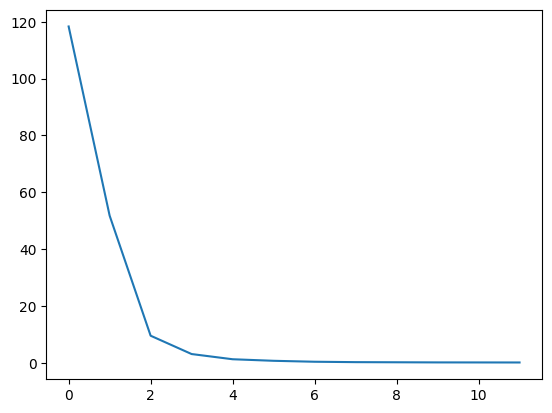

In [ ]:
plt.plot(tnr.history['loss'])

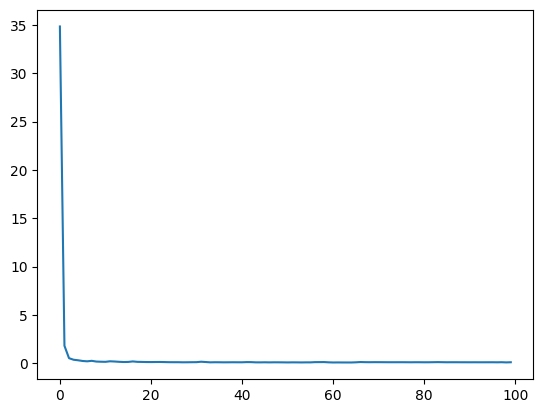

In [ ]:
plt.plot(best_model.history['loss'])